# Detection of Public Health Misinformation on Social Media in Nigeria

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Public_Health_Misinformation_Detection

/content/drive/MyDrive/Colab Notebooks/Public_Health_Misinformation_Detection


## Importing Libraries

In [ ]:
# Import Necessary Lbraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from config import data_path, output_dir, save_model_plot
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import datetime
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
from config import save_model_dir, corona_best_model, lassafever_best_model, maternity_best_model
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, SelectKBest

## Data Acquisition

We'll be working with three different dataset here, which are based on three different topics
> Coronavirus

> Lassa Fever

> Maternity Health

In [ ]:
coronavirus_data = data_path+'corona.xlsx'
maternity_health_data = data_path+'DATABASE FOR MATERNITY HEALTH  (2).xlsx'
lassafever_data = data_path+'DATABASE FOR LASSA FEVER 2.xlsx'

## Data Visualization

In [ ]:
corona = pd.read_excel(coronavirus_data)
maternity_health = pd.read_excel(maternity_health_data)
lassafever = pd.read_excel(lassafever_data)

### Coronavirus Dataset

In [ ]:
corona.columns = ['Tweets', 'Labels', 'Real_Info']
corona.head()

Tweets Labels  Real_Info
0  Imagine a World where there are dangerous path...  False        NaN
1  Are they going to plant a new corona virus in ...  False        NaN
2  132nd/234 remain 234th/132 remain ≡ƒ¬₧ 9/11 Te...  False        NaN
3  I knocked the whole thing off in May 2020. I w...  False        NaN
4  5/11 Mirrored 8/21 this yr 132nd/234 remain 23...  False        NaN

In [ ]:
# Drop the Real_Info Column
corona.drop('Real_Info', axis=1, inplace=True)

In [ ]:
corona.head()

Tweets Labels
0  Imagine a World where there are dangerous path...  False
1  Are they going to plant a new corona virus in ...  False
2  132nd/234 remain 234th/132 remain ≡ƒ¬₧ 9/11 Te...  False
3  I knocked the whole thing off in May 2020. I w...  False
4  5/11 Mirrored 8/21 this yr 132nd/234 remain 23...  False

In [ ]:
corona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  1205 non-null   object
 1   Labels  1205 non-null   object
dtypes: object(2)
memory usage: 19.0+ KB


In [ ]:
len(corona)

1205

In [ ]:
corona.isnull().sum()

Tweets    0
Labels    0
dtype: int64

The visualization highlights significant data preprocessing requirements, revealing 1205 features and two columns.

##### Visualize labels

In [ ]:
for i, labels in enumerate(corona['Labels']):
  if labels not in [False, True]:
    print(f'''
    Tweet: {corona.Tweets[i]}
    Label: {labels} /n
    ''')


    Tweet: Sunak even saying this is terrifyingly cruel on our teens who are still mentally and emotionally vulnerable due to the mishandling of their lives and education through the pandemic. Teach them extra maths and then put them on the frontline. 👏 Err NO!🖕
    Label: FASLE /n
    

    Tweet: “I…
    Label: Undetermined (Incomplete statement without context) /n
    


From the above, we see that there are two samples of the dataset, which have their labels that is not either True or False. The First is due to misplelling, and the second isn't consequential with the dataset. These problems would be addresses below

In [ ]:
### rename mispelled label
corona['Labels'][882] = False

In [ ]:
### Remove Columns with wrong labels
def clean_dataframe(df, label_column):
    """
    Removes rows from the DataFrame where the label is not 'true' or 'false' (case insensitive),
    and converts the remaining labels to lowercase.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    label_column (str): The name of the column containing the labels.

    Returns:
    pd.DataFrame: A cleaned DataFrame with rows removed and labels converted to lowercase.
    """
    # Filter the DataFrame to keep only rows with labels 'true' or 'false'
    valid_labels = {True, False}
    cleaned_df = df[df[label_column].isin(valid_labels)]

    return cleaned_df

In [ ]:
corona_clean = clean_dataframe(corona, 'Labels')

In [ ]:
len(corona_clean)

1204

##### Save Preprocessed Dataset

In [ ]:
path_to_corona_clean_data = data_path + '/Clean Dataset/corona_clean.xlsx'
corona_clean.to_excel(path_to_corona_clean_data)

### Maternity Health Dataset

In [ ]:
maternity_health.columns = ['Tweets','Unamed1', 'Unamed2', 'Unamed3', 'Media', 'Labels', 'Real_Info']
maternity_health.head()

Tweets  Unamed1  Unamed2  \
0  I need mums to start talking about something o...      NaN      NaN   
1  Lesley McEvoy, who lost a lot of blood in chil...      NaN      NaN   
2  During pregnancy, some baby cells migrate into...      NaN      NaN   
3   i never thought i would live long enough to s...      NaN      NaN   
4  Do we all agree that teenage wealth mismanagem...      NaN      NaN   

   Unamed3     Media Labels                                          Real_Info  
0      NaN  Twitter    True                                                NaN  
1      NaN  Twitter    True                                                NaN  
2      NaN  Twitter   False  Some baby cells do migrate into the mother's b...  
3      NaN  Twitter    True                                                NaN  
4      NaN  Twitter    True                                                NaN

In [ ]:
# Drop Unamed Columns and Real_Info Columns
maternity_health.drop(['Unamed1', 'Unamed2', 'Unamed3', 'Real_Info'], axis=1, inplace=True)

In [ ]:
maternity_health.head()

Tweets     Media Labels
0  I need mums to start talking about something o...  Twitter    True
1  Lesley McEvoy, who lost a lot of blood in chil...  Twitter    True
2  During pregnancy, some baby cells migrate into...  Twitter   False
3   i never thought i would live long enough to s...  Twitter    True
4  Do we all agree that teenage wealth mismanagem...  Twitter    True

In [ ]:
maternity_health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  2011 non-null   object
 1   Media   2011 non-null   object
 2   Labels  2011 non-null   object
dtypes: object(3)
memory usage: 47.3+ KB


In [ ]:
maternity_health.isnull().sum()

Tweets    0
Media     0
Labels    0
dtype: int64

In [ ]:
len(maternity_health)

2011

The visualization highlights significant data preprocessing requirements, revealing 2011 features and three columns.

In [ ]:
indexes_with_diff_labels = []

for i, labels in enumerate(maternity_health['Labels']):
  if labels not in [False, True]:
    print(f'''
    Tweet: {maternity_health.Tweets[i]}
    Label: {labels} /n
    ''')
    indexes_with_diff_labels.append(i)


    Tweet: My #clip - MastersLBS 32 weeks pregnant anal play - 3rd pregnancy just sold!
    Label: Uncertain /n
    

    Tweet: Soft landing. Lazy is lazy, ogbeni. If u didn't mean it to ridicule her u would have said it in such manner, go away! Madam comprehension. When u catch dem for leg dem go say na hand. What other meaning could "lazy" have in such context. Mrs pregnancy!
    Label: Uncertain /n
    

    Tweet: Horny talk into Public groping/ teasing into breeding into over powering into impregnation then aftercare then Pregnancy <3 that's the way to my heart.
    Label: Uncertain /n
    

    Tweet: Urgent!!! Azza and Mohammad in Gaza have lost their pharmacy and home. Azza, a teacher,
    Label: Uncertain /n
    

    Tweet: Pleased with the SnapBack 🥹🙌🏽 5 weeks post pregnancy… SHE’S BACK!
    Label: Uncertain /n
    

    Tweet: How do you think this line got there🤔? Here’s what you need to know about this pregnancy line✨....
    Label: Uncertain /n
    

    Tweet: Few hav

In [ ]:
len(indexes_with_diff_labels)

833

From this we see there are 833 samples with labels, which are not between True and False, we'd have to perform more visualization on this so as to understand the data wellm and correct this issue.

In [ ]:
uncertain_samples = maternity_health[maternity_health['Labels'] == 'Uncertain']

# Display the uncertain samples
uncertain_samples

Tweets     Media     Labels
599   My #clip - MastersLBS 32 weeks pregnant anal p...  Twitter   Uncertain
600   Soft landing. Lazy is lazy, ogbeni. If u didn'...  Twitter   Uncertain
609   Horny talk into Public groping/ teasing into b...  Twitter   Uncertain
610   Urgent!!! Azza and Mohammad in Gaza have lost ...  Twitter   Uncertain
624   Pleased with the SnapBack 🥹🙌🏽 5 weeks post pre...  Twitter   Uncertain
...                                                 ...       ...        ...
1980  Go arrest her to go do test to know how many m...  Twitter   Uncertain
1991  substantial factory belong pregnancy technique...  Twitter   Uncertain
1996     aim publish pregnancy mechanism indeed opinion  Twitter   Uncertain
1998  Testosterone is a known teratogen. Is there an...  Twitter   Uncertain
2009  Testosterone is a known teratogen. Is there an...  Twitter   Uncertain

[833 rows x 3 columns]

In [ ]:
# Export the uncertain samples to an Excel file for manual correction
uncertain_samples.to_excel(data_path+'maternity_data_uncertain_samples.xlsx', index=False)

After carefull inspection of the dataset samples with uncertain labels, turns out most, if not all of them are either inconsequential with the dataset, or they are incomplete sentences, so, they will all be dropped out of the dataset, to ensure a model with good performance.

In [ ]:
# Filter out the rows where the label is 'uncertain'
maternity_health_clean = clean_dataframe(maternity_health, 'Labels')

# Display the number of rows before and after cleaning
print("Number of samples before cleaning:", len(maternity_health))
print("Number of samples after cleaning:", len(maternity_health_clean))

Number of samples before cleaning: 2011
Number of samples after cleaning: 1178


In [ ]:
maternity_health_clean.head()

Tweets     Media Labels
0  I need mums to start talking about something o...  Twitter    True
1  Lesley McEvoy, who lost a lot of blood in chil...  Twitter    True
2  During pregnancy, some baby cells migrate into...  Twitter   False
3   i never thought i would live long enough to s...  Twitter    True
4  Do we all agree that teenage wealth mismanagem...  Twitter    True

##### Save Preprocessed Dataset

In [ ]:
path_to_maternity_health_clean_data = data_path + '/Clean Dataset/maternity_health_clean.xlsx'
maternity_health_clean.to_excel(path_to_maternity_health_clean_data)

### Lassafever Dataset

In [ ]:
lassafever.columns = ['Tweets', 'Media', 'Labels', 'Real_Info']
lassafever.head()

Tweets    Media Labels Real_Info
0  What comes to your mind when you hear Lassa fe...  Twitter    NaN       NaN
1  Call for article submission: Submit your paper...  Twitter    NaN       NaN
2  Preparing for CCSE or USMLE Step 2? Try our qu...  Twitter    NaN       NaN
3  If you work with Survival Analysis, Epidemiolo...  Twitter    NaN       NaN
4  "could open safely" Yes absolutely. But the re...  Twitter    NaN       NaN

In [ ]:
# Drop Real Info Column
lassafever.drop('Real_Info', axis=1, inplace=True)

In [ ]:
lassafever.head()

Tweets    Media Labels
0  What comes to your mind when you hear Lassa fe...  Twitter    NaN
1  Call for article submission: Submit your paper...  Twitter    NaN
2  Preparing for CCSE or USMLE Step 2? Try our qu...  Twitter    NaN
3  If you work with Survival Analysis, Epidemiolo...  Twitter    NaN
4  "could open safely" Yes absolutely. But the re...  Twitter    NaN

In [ ]:
lassafever.isnull().sum()

Tweets     0
Media      0
Labels    26
dtype: int64

In [ ]:
lassafever.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  414 non-null    object
 1   Media   414 non-null    object
 2   Labels  388 non-null    object
dtypes: object(3)
memory usage: 9.8+ KB


In [ ]:
len(lassafever)

414

The visualization highlights significant modelling requirements, revealing 414 features and three columns.

In [ ]:
lassafever_indexes_with_diff_labels = []

for i, labels in enumerate(lassafever['Labels']):
  if labels not in [False, True]:
    print(f'''
    Tweet: {lassafever.Tweets[i]}
    Label: {labels}
    Index: {i}
    ''')
    lassafever_indexes_with_diff_labels.append(i)


    Tweet: What comes to your mind when you hear Lassa fever? Before you think what you’re thinking in your mind, watch this video…
    Label: nan
    Index: 0
    

    Tweet: Call for article submission: Submit your paper work on:
    Label: nan
    Index: 1
    

    Tweet: Preparing for CCSE or USMLE Step 2? Try our quizzes
    Label: nan
    Index: 2
    

    Tweet: If you work with Survival Analysis, Epidemiology, and Gene Expression and you want to unlock the secrets of Longitudinal Data using Rstats, have a look at our course in November.
    Label: nan
    Index: 3
    

    Tweet: "could open safely" Yes absolutely. But the real mode of transmission was denied. Mitigations that would work (N95 Filtration & Ventilation) were not adequately present until far too late and discarded too early. Covid Is Not Over.
    Label: nan
    Index: 4
    

    Tweet: Preparing for CCSE or USMLE Step 2? Try our quizzes
    Label: nan
    Index: 5
    

    Tweet: Open PhD position in plant

In [ ]:
len(lassafever_indexes_with_diff_labels)

47

From this, we see there are 47 samples with labels, that aren't True or False, and after thorough analysis, of these samples, and thier corresponding labels, most of the samples are not consequential with the data we are working with are incomlete sentences.

In [ ]:
# Filter out the rows where the label is not True/False
lassafever_clean = clean_dataframe(lassafever, 'Labels')

# Display the number of rows before and after cleaning
print("Number of samples before cleaning:", len(lassafever))
print("Number of samples after cleaning:", len(lassafever_clean))

Number of samples before cleaning: 414
Number of samples after cleaning: 367


In [ ]:
lassafever_clean

Tweets     Media Labels
6    Study finds human body lice can transmit plagu...   Twitter   True
7    The State Ministry of Health, in collaboration...   Twitter   True
8    More than 17 billion € spent every year by peo...   Twitter   True
10   New Study Predicts Major Leap in Global Life E...   Twitter   True
12   The pandemic continues. Unchecked transmission...   Twitter   True
..                                                 ...       ...    ...
409      Lassa fever only occurs in the winter months.  Facebook  False
410  Herbal supplements do not cure Lassa fever; an...  Facebook  False
411  Lassa fever can be spread by sitting next to a...  Facebook  False
412  Lassa fever can be treated effectively with ho...   Twitter  False
413  Lassa fever only affects adults over the age o...   Twitter  False

[367 rows x 3 columns]

###### Save Preprocessed Dataset

In [ ]:
path_to_lassafever_clean_data = data_path + '/Clean Dataset/lassafever_clean.xlsx'
lassafever_clean.to_excel(path_to_lassafever_clean_data)

## Data Visualization/Analysis

In [ ]:
### Import Cleaned Data
corona_dataset = pd.read_excel(data_path+'Clean Dataset/corona_clean.xlsx')
lassa_dataset = pd.read_excel(data_path+'Clean Dataset/lassafever_clean.xlsx')
maternity_dataset = pd.read_excel(data_path+'Clean Dataset/maternity_health_clean.xlsx')

### Coronavirus Data Visualization

In [ ]:
# Use numpy's unique function to get the counts of each unique label
unique_labels, counts = np.unique(corona_dataset.Labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Label: False, Count: 605
Label: True, Count: 599


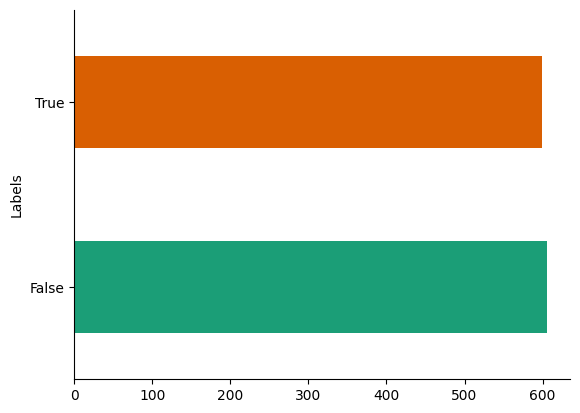

In [ ]:
## Visualize the Label Distribution in the Dataset
corona_dataset.groupby('Labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

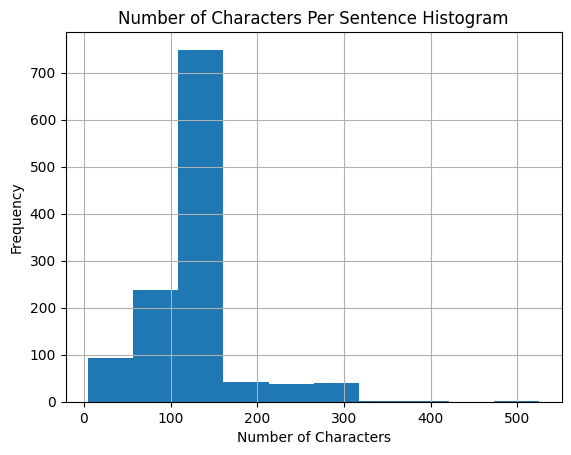

In [ ]:
plt.figure();
corona_dataset['Tweets'].str.len().hist();
plt.title('Number of Characters Per Sentence Histogram');
plt.xlabel('Number of Characters');
plt.ylabel('Frequency');

The histogram shows that the text dataset range from around 5 to about 500 characters and generally, it is between 100 to 150 characters.

In [ ]:
# Check for missing values
corona_dataset.isna().sum()

Unnamed: 0    0
Tweets        0
Labels        0
dtype: int64

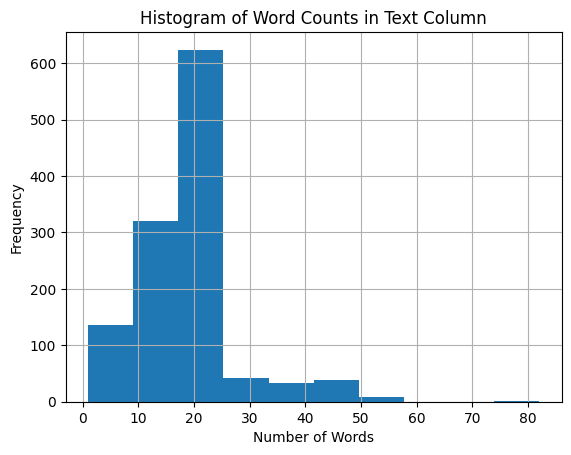

In [ ]:
plt.figure()
corona_dataset['text'] = corona_dataset['Tweets'].fillna('').astype(str)
corona_dataset['text'].str.split().map(lambda x: len(x)).hist()
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts in Text Column')
plt.show()

This Histogram shows that most sentences have a word frequency between 10 to 24

Text(0, 0.5, 'Frequency')

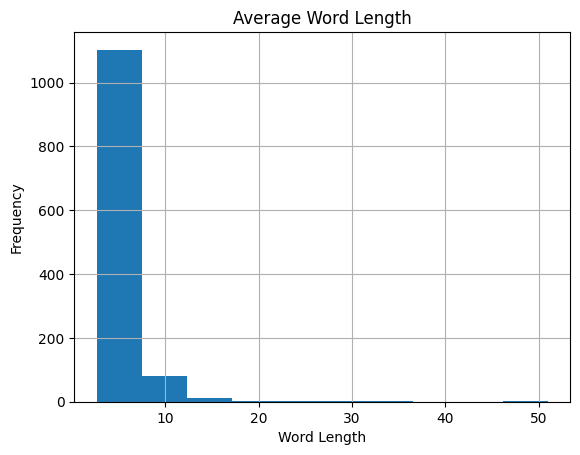

In [ ]:
plt.figure();
corona_dataset['Tweets'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist();
plt.title('Average Word Length');
plt.xlabel('Word Length')
plt.ylabel('Frequency')

The average word length ranges between 3 to about 30. The histogram is left skewed, this might be as a result of stopwords present in the dataset, making most word length small in length.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


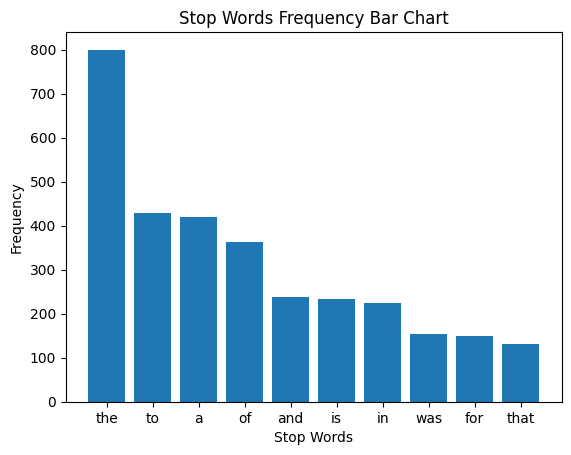

In [ ]:
## Stop Words Analysis
nltk.download('stopwords')

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)
    plt.xlabel('Stop Words')
    plt.ylabel('Frequency')
    plt.title('Stop Words Frequency Bar Chart')

plot_top_stopwords_barchart(corona_dataset['Tweets'])

This Bar Chart shows the Freuqency plot of all the stop words existing in the dataset, from the plot 'the' as the highest frquency, followed by 'to' and 'a'

<ipython-input-135-75cb73a64e1d>:19: UserWarning: 
The palette list has fewer values (7) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=y,y=x, palette=palette, hue=y, legend=False)


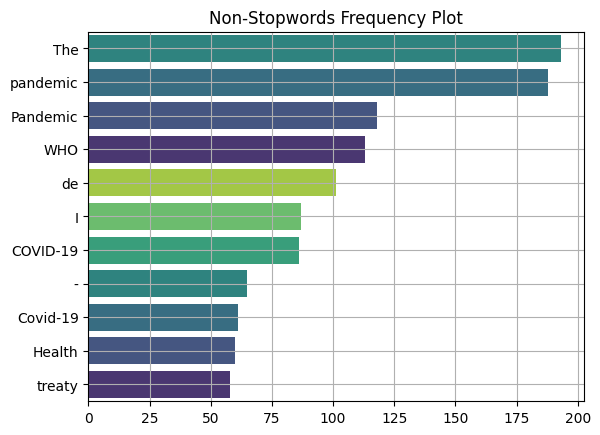

In [ ]:
# Word Level Analysis: Visualization of Non-Stopwords Frequency
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    palette = sns.color_palette("viridis", 7)

    sns.barplot(x=y,y=x, palette=palette, hue=y, legend=False)
    plt.title('Non-Stopwords Frequency Plot')
    plt.grid(True)

plot_top_non_stopwords_barchart(corona_dataset['Tweets'])

One significant insight from the plot above is the necessity of consistent text preprocessing techniques for our dataset. For example, the presence of the word ‘The’ in uppercase highlights a key issue: stop words such as “the” might not be categorized correctly if text is not standardized to lowercase. In this case, ‘The’ was not identified as a stop word due to its capitalization, which can lead to inaccuracies in text analysis.

To address such issues and ensure effective text processing, we must implement several crucial preprocessing steps:

* Text Normalization
* Removal of Non-Words
* Stop Word Removal

By performing these preprocessing tasks, we can enhance the quality of our text data, leading to more accurate and effective text analysis and machine learning model performance.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


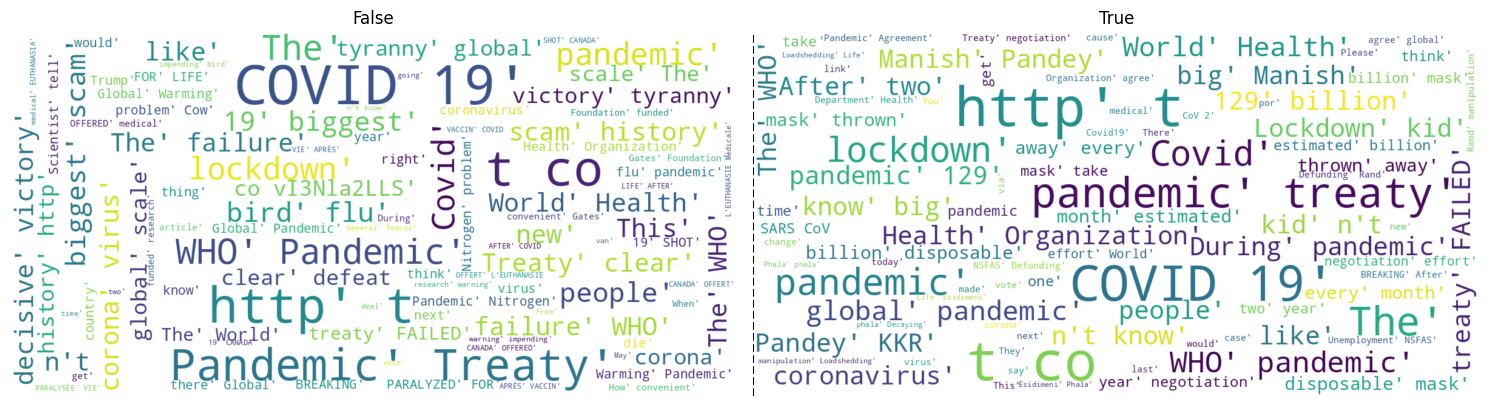

In [ ]:
def plot_wordcloud(text, ax, title):
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    stop = set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus = []
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in text:
            # Ensure 'news' is a string
            if isinstance(news, str):
                words = [w for w in word_tokenize(news) if (w not in stop)]

                words = [lem.lemmatize(w) for w in words if len(w) > 2]

                corpus.append(words)
        return corpus

    corpus = _preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud = wordcloud.generate(str(corpus))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot wordcloud for each label
labels = corona_dataset['Labels'].unique()
for i, label in enumerate(labels):
    dataset_for_label = corona_dataset[corona_dataset['Labels'] == label]
    plot_wordcloud(dataset_for_label['Tweets'], axs[i], label)

# Add a vertical line between the subplots
plt.axvline(x=0.5, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
corona_sentences = corona_dataset['Tweets']
corona_labels = corona_dataset['Labels']

In [ ]:
# Get the average number of tokens, (words) per text in the dataset
average_number_of_tokens = round(sum([len(i.split()) for i in corona_sentences.astype(str)])/len(corona_sentences))
average_number_of_tokens

19

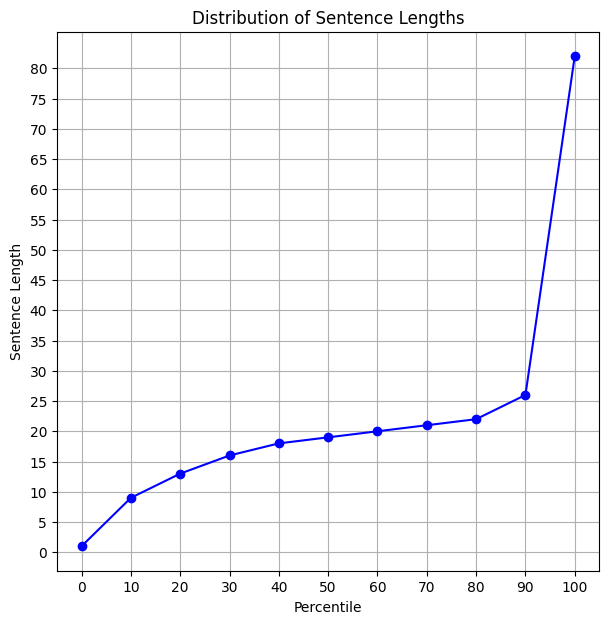

In [ ]:
# Get a list of all the sentence lenghts
sentences_len = [len(i.split()) for i in corona_sentences.astype(str)]

# Calculate percentiles
percentiles = np.arange(0, 101, 10)
percentile_values = np.percentile(sentences_len, percentiles)

# Plot percentiles
plt.figure(figsize=(7, 7))
plt.plot(percentiles, percentile_values, marker='o', color='b')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Percentile')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, max(sentences_len) + 1,5), rotation=360)
plt.show()

From this plot, we see that 90% of the sentences have sentence length equal to 25, or below it. But just 10% have sentence length between 25 to 82, therefore, max number of words in each sentence, would be set to the 70th percentile, which is 21

### Maternity Health Dataset

In [ ]:
# Use numpy's function to get the counts of each unique label
unique_labels, counts = np.unique(maternity_dataset.Labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Label: False, Count: 214
Label: True, Count: 964


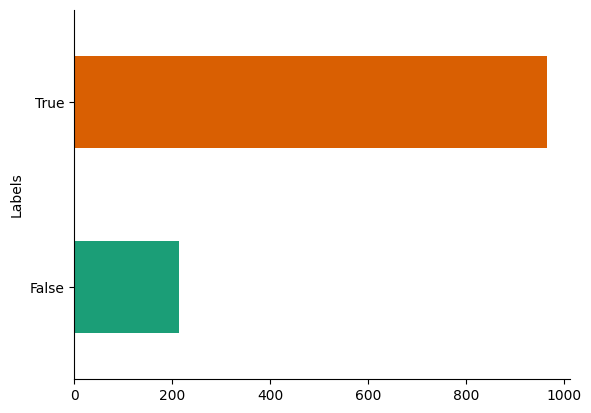

In [ ]:
## Visualize the Label Distribution in the Dataset
maternity_dataset.groupby('Labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

From the plot above, it is very obvious that the dataset is a lot imbalanced, as the Samples with True labels are far much more than those with false. This would be taken note of, and necessary techniques, such as oversampling, undersampling, text augmentaion, applying class weights to models, would be carried out, during the preprocessing step.

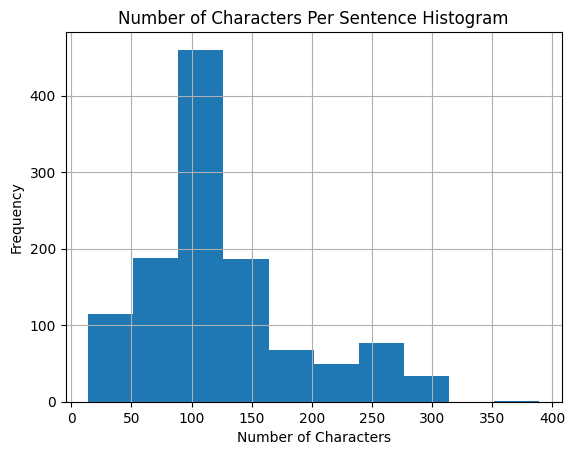

In [ ]:
plt.figure();
maternity_dataset['Tweets'].str.len().hist();
plt.title('Number of Characters Per Sentence Histogram');
plt.xlabel('Number of Characters');
plt.ylabel('Frequency');

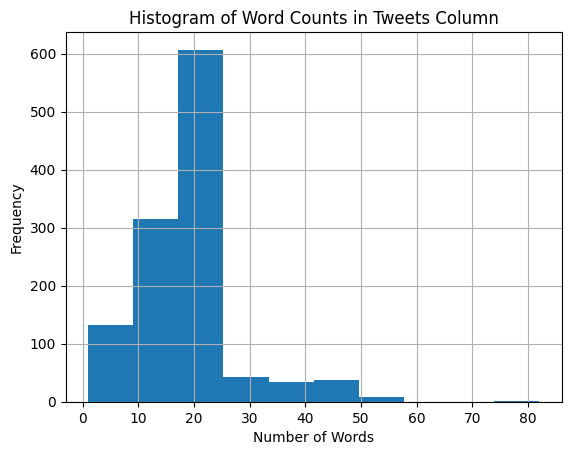

In [ ]:
plt.figure()
maternity_dataset['text'] = corona_dataset['Tweets'].fillna('').astype(str)
maternity_dataset['text'].str.split().map(lambda x: len(x)).hist()
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts in Tweets Column')
plt.show()

Text(0, 0.5, 'Frequency')

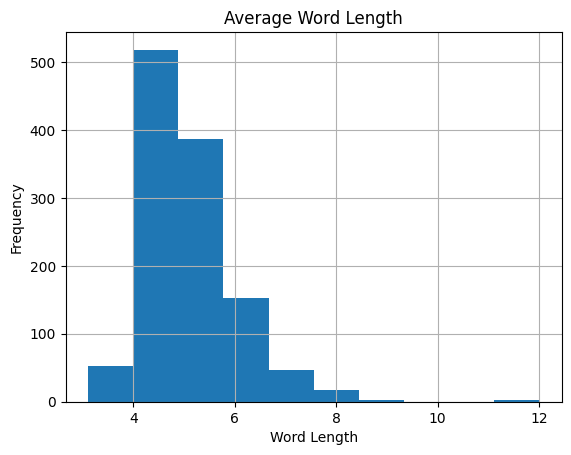

In [ ]:
plt.figure();
maternity_dataset['Tweets'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist();
plt.title('Average Word Length');
plt.xlabel('Word Length')
plt.ylabel('Frequency')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


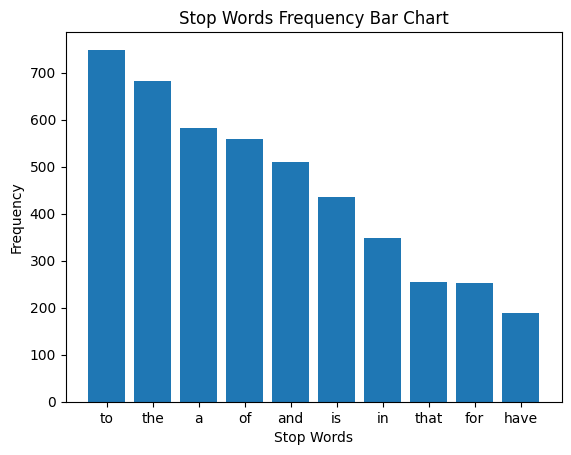

In [ ]:
## Stop Words Analysis
nltk.download('stopwords')

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)
    plt.xlabel('Stop Words')
    plt.ylabel('Frequency')
    plt.title('Stop Words Frequency Bar Chart')

plot_top_stopwords_barchart(maternity_dataset['Tweets'])

<ipython-input-154-7ef18afb43b8>:19: UserWarning: 
The palette list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=y,y=x, palette=palette, hue=y, legend=False)


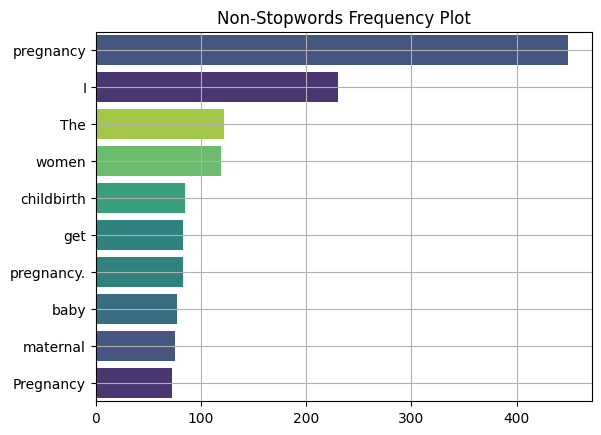

In [ ]:
# Word Level Analysis: Visualization of Non-Stopwords Frequency
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    palette = sns.color_palette("viridis", 7)

    sns.barplot(x=y,y=x, palette=palette, hue=y, legend=False)
    plt.title('Non-Stopwords Frequency Plot')
    plt.grid(True)

plot_top_non_stopwords_barchart(maternity_dataset['Tweets'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


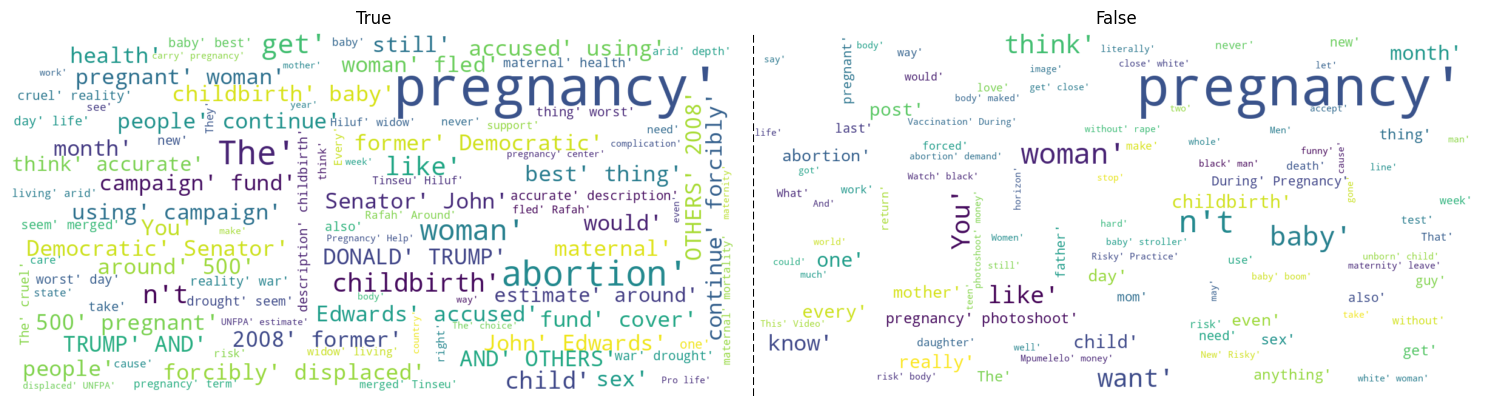

In [ ]:
def plot_wordcloud(text, ax, title):
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    stop = set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus = []
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in text:
            # Ensure 'news' is a string
            if isinstance(news, str):
                words = [w for w in word_tokenize(news) if (w not in stop)]

                words = [lem.lemmatize(w) for w in words if len(w) > 2]

                corpus.append(words)
        return corpus

    corpus = _preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud = wordcloud.generate(str(corpus))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot wordcloud for each label
labels = maternity_dataset['Labels'].unique()
for i, label in enumerate(labels):
    dataset_for_label = maternity_dataset[maternity_dataset['Labels'] == label]
    plot_wordcloud(dataset_for_label['Tweets'], axs[i], label)

# Add a vertical line between the subplots
plt.axvline(x=0.5, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
maternity_sentences = maternity_dataset['Tweets']
maternity_labels = maternity_dataset['Labels']

In [ ]:
# Get the average number of tokens, (words) per text in the dataset
average_number_of_tokens_for_maternity_data = round(sum([len(i.split()) for i in maternity_sentences.astype(str)])/len(maternity_sentences))
average_number_of_tokens_for_maternity_data

22

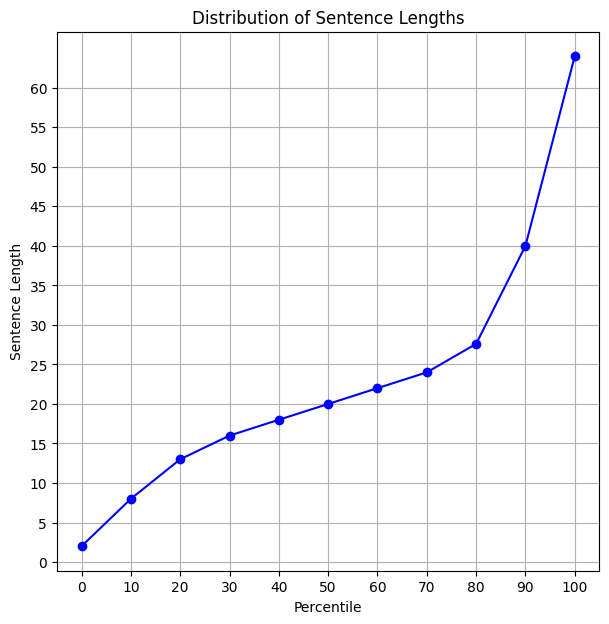

In [ ]:
# Get a list of all the sentence lenghts
sentences_len = [len(i.split()) for i in maternity_sentences.astype(str)]

# Calculate percentiles
percentiles = np.arange(0, 101, 10)
percentile_values = np.percentile(sentences_len, percentiles)

# Plot percentiles
plt.figure(figsize=(7, 7))
plt.plot(percentiles, percentile_values, marker='o', color='b')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Percentile')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, max(sentences_len) + 1,5), rotation=360)
plt.show()

### Lassfever Dataset

In [ ]:
# Use numpy's function to get the counts of each unique label
unique_labels, counts = np.unique(lassa_dataset.Labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Label: False, Count: 142
Label: True, Count: 225


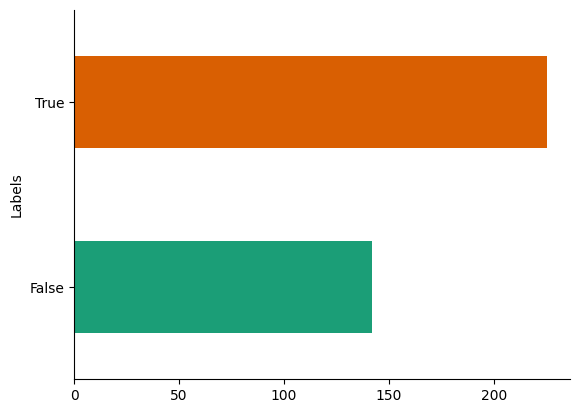

In [ ]:
## Visualize the Label Distribution in the Dataset
lassa_dataset.groupby('Labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

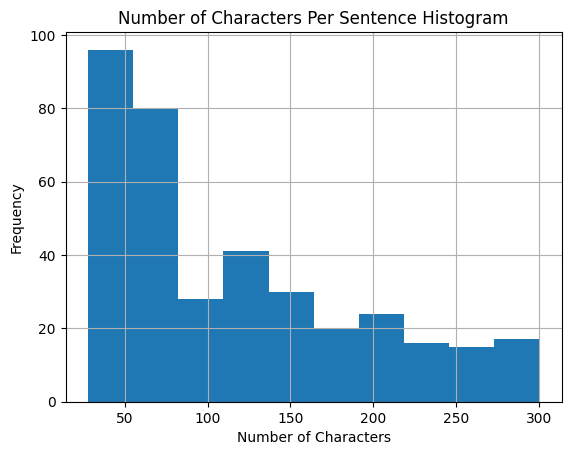

In [ ]:
plt.figure();
lassa_dataset['Tweets'].str.len().hist();
plt.title('Number of Characters Per Sentence Histogram');
plt.xlabel('Number of Characters');
plt.ylabel('Frequency');

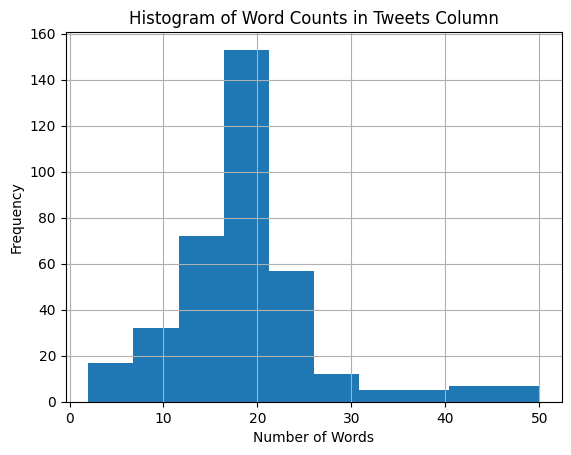

In [ ]:
plt.figure()
lassa_dataset['text'] = corona_dataset['Tweets'].fillna('').astype(str)
lassa_dataset['text'].str.split().map(lambda x: len(x)).hist()
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts in Tweets Column')
plt.show()

Text(0, 0.5, 'Frequency')

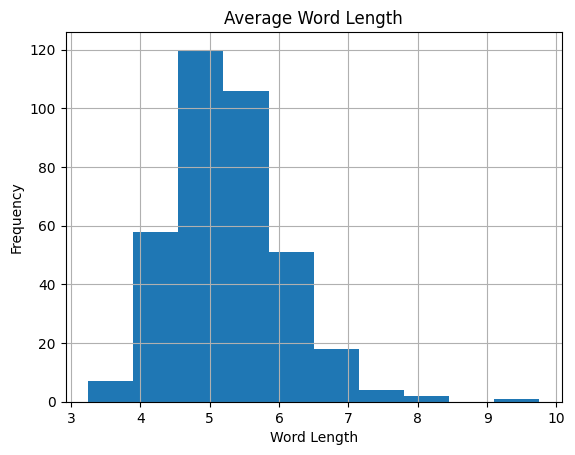

In [ ]:
plt.figure();
lassa_dataset['Tweets'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist();
plt.title('Average Word Length');
plt.xlabel('Word Length')
plt.ylabel('Frequency')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


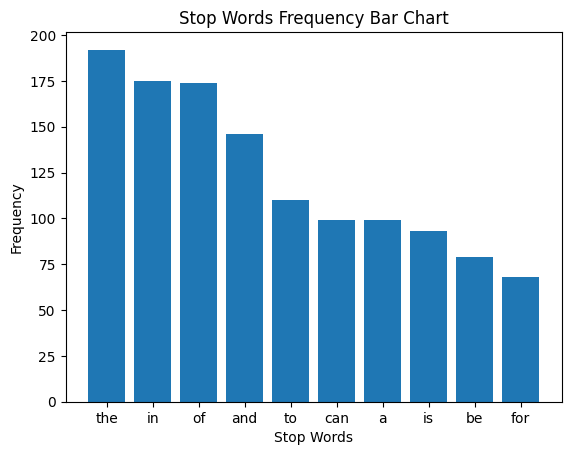

In [ ]:
## Stop Words Analysis
nltk.download('stopwords')

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)
    plt.xlabel('Stop Words')
    plt.ylabel('Frequency')
    plt.title('Stop Words Frequency Bar Chart')

plot_top_stopwords_barchart(lassa_dataset['Tweets'])

<ipython-input-169-ef2d2e7c612e>:19: UserWarning: 
The palette list has fewer values (7) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=y,y=x, palette=palette, hue=y, legend=False)


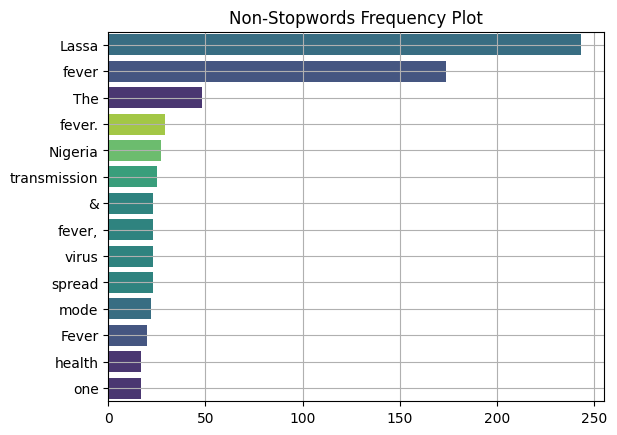

In [ ]:
# Word Level Analysis: Visualization of Non-Stopwords Frequency
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    palette = sns.color_palette("viridis", 7)

    sns.barplot(x=y,y=x, palette=palette, hue=y, legend=False)
    plt.title('Non-Stopwords Frequency Plot')
    plt.grid(True)

plot_top_non_stopwords_barchart(lassa_dataset['Tweets'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


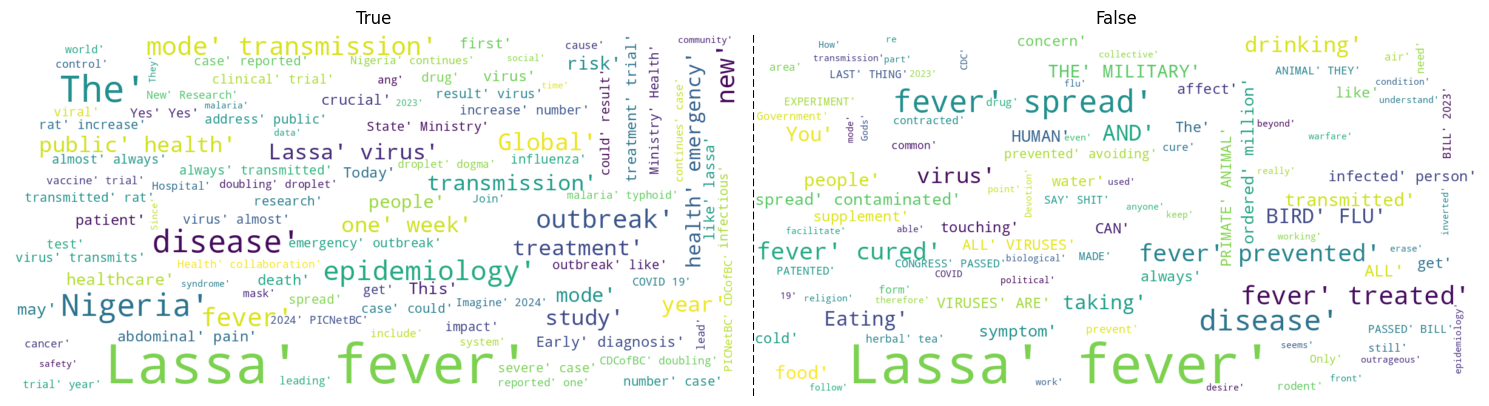

In [ ]:
def plot_wordcloud(text, ax, title):
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    stop = set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus = []
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in text:
            # Ensure 'news' is a string
            if isinstance(news, str):
                words = [w for w in word_tokenize(news) if (w not in stop)]

                words = [lem.lemmatize(w) for w in words if len(w) > 2]

                corpus.append(words)
        return corpus

    corpus = _preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud = wordcloud.generate(str(corpus))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot wordcloud for each label
labels = lassa_dataset['Labels'].unique()
for i, label in enumerate(labels):
    dataset_for_label = lassa_dataset[lassa_dataset['Labels'] == label]
    plot_wordcloud(dataset_for_label['Tweets'], axs[i], label)

# Add a vertical line between the subplots
plt.axvline(x=0.5, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
lassafever_sentences = lassa_dataset['Tweets']
lassafever_labels = lassa_dataset['Labels']

In [ ]:
# Get the average number of tokens, (words) per text in the dataset
average_number_of_tokens_for_lassafever_data = round(sum([len(i.split()) for i in lassafever_sentences.astype(str)])/len(lassafever_sentences))
average_number_of_tokens_for_lassafever_data

19

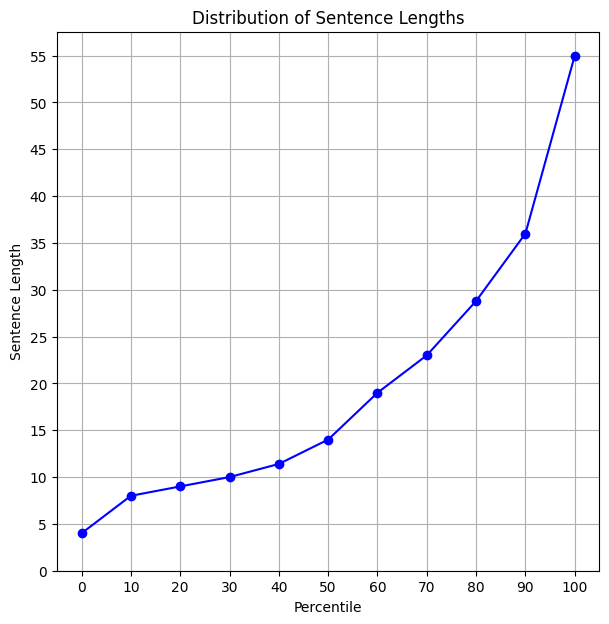

In [ ]:
# Get a list of all the sentence lenghts
sentences_len = [len(i.split()) for i in lassafever_sentences.astype(str)]

# Calculate percentiles
percentiles = np.arange(0, 101, 10)
percentile_values = np.percentile(sentences_len, percentiles)

# Plot percentiles
plt.figure(figsize=(7, 7))
plt.plot(percentiles, percentile_values, marker='o', color='b')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Percentile')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, max(sentences_len) + 1,5), rotation=360)
plt.show()

## Data Preprocessing
From the Data Visualization performed for each of the datasets above, we see the data preprocessing steps needed for each of the dataset, before modelling. These steps would be taken for each of the dataset in this section.

The following steps would be generally taken for all the datasets

##### 1. Reading in Saved Preprocessed Dataset from Disk
##### 2. Data Cleaning: Removal of Punctuation
##### 3. Tokenization
##### 4. Data Cleaning: Removal of Stop Words
##### 5. Lemmatization
##### 6. Vectorization
##### 8. Train Test Split

In [ ]:
# Import Cleaned Dataset
original_corona_data = pd.read_excel(data_path+'Clean Dataset/corona_clean.xlsx')
original_lassa_data = pd.read_excel(data_path+'Clean Dataset/lassafever_clean.xlsx')
maternity_dataset = pd.read_excel(data_path+'Clean Dataset/maternity_health_clean.xlsx')

In [ ]:
original_lassa_data.drop(['Media'], axis=1,  inplace=True)
original_corona_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
# Append new dataset of lassafever, and coronavirus
new_corona_dataset = pd.read_excel(data_path + 'covid_updated.xlsx')
new_lassa_dataset = pd.read_excel(data_path +'updated_lassa.xlsx')

new_lassa_dataset.fillna('', inplace=True)
new_lassa_dataset.columns = ['Tweets', 'Labels']

new_corona_dataset.fillna('', inplace=True)
new_corona_dataset.columns = ['Tweets', 'Labels']

corona_dataset = pd.concat([original_corona_data, new_corona_dataset], ignore_index=True)
lassa_dataset = pd.concat([original_lassa_data, new_lassa_dataset], ignore_index=True)

# Print the shapes of the datasets to confirm the concatenation
print("Corona Dataset Shape:", corona_dataset.shape)
print("Lassa Dataset Shape:", lassa_dataset.shape)

Corona Dataset Shape: (1519, 2)
Lassa Dataset Shape: (547, 3)


In [ ]:
# Data Preprocessing Class
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')


class Preprocess():
    @staticmethod
    def train_test_split(X, y, test_size=0.2):
        X_train, X_test, y_train, y_test = train_test_split(
            np.array(X), np.array(y), stratify=y, test_size=test_size, random_state=42)

        return (X_train, X_test, y_train, y_test)

    @staticmethod
    def remove_punctuations(text):
      # Ensure the text is in string format
      if isinstance(text, bytes):
        text = text.decode('utf-8')
      elif isinstance(text, np.ndarray):
        text = text.astype(str)
      elif isinstance(text, datetime.datetime):
        # convert datetime dtype to string
        text = text.strftime('%Y-%m-%d %H:%M:%S')
        # convert other non text dtype to text
      elif not isinstance(text, str):
        text = str(text)

      # Convert text to lowercase using numpy's char.lower if it is a numpy array
      lowercase_text = text.lower()
      # Remove punctuations using regex
      removed_punctuations = re.sub(r'[^\w\s]', '', lowercase_text)
      return removed_punctuations

    @staticmethod
    def tokenizer(text):
        '''
        This Function performs word level tokenization
        for the input data, using the nltk (Natural Language Processing Toolkit) library
        '''

        return word_tokenize(text)

    @staticmethod
    def remove_stop_words(tokenized_text):
        '''
        This function implements the nltk library to remove stop words
        from the dataset
        '''

        var_stop_words = set(stopwords.words('english'))
        words = tokenized_text
        words_filtered = [word for word in words if word.isalpha()
                          and word not in var_stop_words]

        return words_filtered

    @staticmethod
    def get_wordnet_pos(word):
      """Map POS tag to first character lemmatize() accepts"""
      tag = nltk.pos_tag([word])[0][1][0].upper()
      tag_dict = {"J": wordnet.ADJ,
                  "N": wordnet.NOUN,
                  "V": wordnet.VERB,
                  "R": wordnet.ADV}
      return tag_dict.get(tag, wordnet.NOUN)

    @staticmethod
    def lemmatize(text):
      if isinstance(text, list):
        lemmatizer = WordNetLemmatizer()
        words_filtered = [lemmatizer.lemmatize(word, Preprocess.get_wordnet_pos(word)) for word in text]
        return words_filtered
      else:
        raise ValueError('Input should be a list of words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
!pip install nlpaug
!pip install langdetect
!pip install googletrans==4.0.0-rc1
!pip install --upgrade pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=b19267ecf3ead89e4b536245781df80c56bf3a20a4ae633fe905090f680a0c4d
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6

In [ ]:
# Text Aumgnentation Class: Conversion of Non English words to English
import nlpaug.augmenter.word as naw
from langdetect import detect
from googletrans import Translator
from spellchecker import SpellChecker

class TextAugmentation:
    def __init__(self, train_sentences, train_labels):
        self.train_sentences = train_sentences
        self.train_labels = train_labels
        self.translator = Translator()
        self.spell = SpellChecker()

    def translate_text(self, text):
        try:
            if text and detect(text) != 'en':
                print(f'Found non en words {text}')
                translated = self.translator.translate(text, src=detect(text), dest='en')
                return translated.text
            else:
                return text
        except Exception as e:
            print(f"Translation error: {e}")
            return text

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text

    def preprocess_text(self, sentences):
        preprocessed_sentences = []
        for sentence in sentences:
            sentence = self.translate_text(sentence)
            sentence = self.clean_text(sentence)
            preprocessed_sentences.append(sentence)
        return preprocessed_sentences

    def augment_all(self):
        # Preprocess text before augmentation
        print("Preprocessing text...")
        sentences = self.preprocess_text(self.train_sentences)

        return sentences, self.train_labels

### **CoronaVirus Data Preprocessing**

#### Shuffle Dataset and split Features and Labels

In [ ]:
# Shuffle  dataset
corona_shuffled = corona_dataset.sample(frac=1, random_state=30)

In [ ]:
corona_shuffled

Tweets  Labels
1250  COVID-19 only affects people with preexisting ...   False
840   Dear Mr Tedros, The reason nobody trusts you o...   False
961            Covid-19 was the biggest scam in history   False
965                                Dr. Reiner Fuellmich   False
125   We have won a decisive victory against tyranny...   False
...                                                 ...     ...
919   Virtual meetings and remote work have increase...    True
1164  @tagesschau Überall Nazis. Am besten ein Nazi-...   False
500   Tembisa Hospital bosses splurged R500 000 on a...   False
941   ¡Contra las antiélites globalistas! ¡¡Buena no...    True
421                                     Spent $151.5 m…   False

[1519 rows x 2 columns]

In [ ]:
corona_text = corona_shuffled['Tweets']
corona_labels = corona_shuffled['Labels']

#### Removal of Punctuation Marks

In [ ]:
corona_removed_punc_text = corona_text.apply(Preprocess.remove_punctuations)

In [ ]:
corona_removed_punc_text

1250    covid19 only affects people with preexisting c...
840     dear mr tedros the reason nobody trusts you or...
961               covid19 was the biggest scam in history
965                                   dr reiner fuellmich
125     we have won a decisive victory against tyranny...
                              ...                        
919     virtual meetings and remote work have increase...
1164    tagesschau überall nazis am besten ein naziloc...
500     tembisa hospital bosses splurged r500 000 on a...
941       contra las antiélites globalistas buena noticia
421                                          spent 1515 m
Name: Tweets, Length: 1519, dtype: object

#### Tokenization

In [ ]:
corona_tokenized_text = corona_removed_punc_text.apply(Preprocess.tokenizer)

In [ ]:
corona_tokenized_text

1250    [covid19, only, affects, people, with, preexis...
840     [dear, mr, tedros, the, reason, nobody, trusts...
961       [covid19, was, the, biggest, scam, in, history]
965                               [dr, reiner, fuellmich]
125     [we, have, won, a, decisive, victory, against,...
                              ...                        
919     [virtual, meetings, and, remote, work, have, i...
1164    [tagesschau, überall, nazis, am, besten, ein, ...
500     [tembisa, hospital, bosses, splurged, r500, 00...
941     [contra, las, antiélites, globalistas, buena, ...
421                                      [spent, 1515, m]
Name: Tweets, Length: 1519, dtype: object

#### Removal of Stop Words

In [ ]:
corona_text_removed_stop_words = corona_tokenized_text.apply(Preprocess.remove_stop_words)

In [ ]:
corona_text_removed_stop_words

1250           [affects, people, preexisting, conditions]
840     [dear, mr, tedros, reason, nobody, trusts, des...
961                              [biggest, scam, history]
965                               [dr, reiner, fuellmich]
125     [decisive, victory, tyranny, global, scale, fa...
                              ...                        
919     [virtual, meetings, remote, work, increased, p...
1164    [tagesschau, überall, nazis, besten, ein, nazi...
500     [tembisa, hospital, bosses, splurged, shipment...
941     [contra, las, antiélites, globalistas, buena, ...
421                                               [spent]
Name: Tweets, Length: 1519, dtype: object

#### Lemmatization

In [ ]:
corona_lemmatized_text = corona_text_removed_stop_words.apply(Preprocess.lemmatize)

In [ ]:
corona_lemmatized_text

1250                [affect, people, preexist, condition]
840     [dear, mr, tedros, reason, nobody, trust, desi...
961                                  [big, scam, history]
965                               [dr, reiner, fuellmich]
125     [decisive, victory, tyranny, global, scale, fa...
                              ...                        
919     [virtual, meeting, remote, work, increase, pan...
1164    [tagesschau, überall, nazi, besten, ein, nazil...
500     [tembisa, hospital, boss, splurge, shipment, g...
941     [contra, la, antiélites, globalistas, buena, n...
421                                               [spent]
Name: Tweets, Length: 1519, dtype: object

#### Train and Test Split

In [ ]:
## Convert Labels, into binary format (0 & 1)
label_mapping = {False:0,
                 True:1}

corona_binary_labels = [label_mapping[label] for label in corona_labels]

In [ ]:
corona_binary_labels[:20]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]

In [ ]:
# join words in the list, to form a sentence
corona_sentences = [' '.join(words) for words in corona_lemmatized_text]

In [ ]:
#Visualize corona sentences
corona_sentences[:10]

['affect people preexist condition',
 'dear mr tedros reason nobody trust desire global pandemic treaty know know',
 'big scam history',
 'dr reiner fuellmich',
 'decisive victory tyranny global scale failure pandemic treaty clear defeat',
 'rt today mark opening cochairs independent expert council urge world leader support neg',
 'lead multisystem inflammatory syndrome child misc',
 'knock whole thing may write blog article national response agenda think st',
 'despues de pasarme años queriendo salir pasear sin poder por la fatiga el dolor creedme cuando o digo q este encie',
 'pandemic treaty fail couldnt reach agreeme']

In [ ]:
# Split into training and validation Splits
corona_train_sentences, corona_val_sentences, corona_train_labels, corona_val_labels = Preprocess.train_test_split(corona_sentences, corona_binary_labels, test_size=0.15)

In [ ]:
len(corona_train_sentences), len(corona_val_sentences), len(corona_train_labels), len(corona_val_labels)

(1291, 228, 1291, 228)

#### Remove Empty Strings from Train Sentences, and their Corresponding Labels

In [ ]:
# Ensure that the lengths match before cleaning
assert len(corona_train_sentences) == len(corona_train_labels)

# Identify non-empty sentences
non_empty_indices = corona_train_sentences != ''

# Filter sentences and labels using these indices
corona_train_sentences_clean = corona_train_sentences[non_empty_indices]
corona_train_labels_clean = corona_train_labels[non_empty_indices]

# Ensure that the lengths match after cleaning
assert len(corona_train_sentences_clean) == len(corona_train_labels_clean)

print("Cleaned sentences length:", len(corona_train_sentences_clean))
print("Corresponding labels length:", len(corona_train_labels_clean))

Cleaned sentences length: 1291
Corresponding labels length: 1291


In [ ]:
corona_train_sentences_clean[:10]

array(['por qué e importante vacunarse contra la la posibilidades de complicaciones graf com',
       'coronazahlen halle saale aktuell inzidenz für halle saale sachsenanhalt und deutschland link image link',
       'paralyze life shot canada offer medical euthanasia medical proof story link dona',
       'マッカロー博士 速報 ワクチンを接種していない場合特定の年齢層でコロナウイルス感染率が低くなることも判明しました 新型コロナウイルス 健康 mrnaワクチン 反ワクチン ワクチン',
       'like malaria',
       'next pandemic public health official say sure come sound like threat impose globalist dysto',
       'eric trump spent', 'big scam history',
       'berita terbaik hari ini gagal negosiasi penetapan pandemic treaty setelah negara menolak pandemic treaty dan han',
       'mtgrepp yes do much damage people lie could ever think start pandemic kill million ok long vaccine covid symptom affected breathing put oxygen live subsequently hiv encephalopathy aid dementia complex lead longterm cognitive impairment discover base emerge literature reasonable hypothesize somewh

#### Data Augmentation of Corona Text

In [ ]:
text_augmenter = TextAugmentation(corona_train_sentences_clean, corona_train_labels_clean)
corona_augmented_sentences, corona_augmented_labels = text_augmenter.augment_all()

print("Augmented Sentences:", corona_augmented_sentences)
print("Corresponding Labels:", corona_augmented_labels)

Preprocessing text...
Found non en words por qué e importante vacunarse contra la la posibilidades de complicaciones graf com
Found non en words coronazahlen halle saale aktuell inzidenz für halle saale sachsenanhalt und deutschland link image link
Found non en words マッカロー博士 速報 ワクチンを接種していない場合特定の年齢層でコロナウイルス感染率が低くなることも判明しました 新型コロナウイルス 健康 mrnaワクチン 反ワクチン ワクチン
Found non en words like malaria
Found non en words eric trump spent
Found non en words berita terbaik hari ini gagal negosiasi penetapan pandemic treaty setelah negara menolak pandemic treaty dan han
Found non en words common cold corona virus incredible damage airborne mutate
Found non en words affect cardiovascular system
Found non en words vaccine contain harmful ingredient
Found non en words hoax
Found non en words avoid get vaccine allergy
Found non en words rt berita terbaik hari ini gagal negosiasi penetapan pandemic treaty setelah negara menolak pandemic treaty dan han
Found non en words estimate remains low quintile level see

In [ ]:
pd.DataFrame({'Real Text': corona_train_sentences_clean,
              'Translated Text': corona_augmented_sentences,
              'Labels': corona_augmented_labels}).to_excel(data_path+'Clean Dataset/augmented_corona_dataset.xlsx', index=False)

In [ ]:
## Augmentation of val_sentences
corona_val_sentences_augmenter = TextAugmentation(corona_val_sentences, corona_val_labels)
corona_val_augmented_sentences, corona_val_augmented_labels = corona_val_sentences_augmenter.augment_all()

print("Augmented Sentences:", corona_val_augmented_sentences)
print("Corresponding Labels:", corona_val_augmented_labels)

Preprocessing text...
Found non en words note eu get well respond recent crisis
Found non en words virus contagious
Found non en words die wäre viel billiger al die steuerausfälle bei krankheitstagen das lindner die gelder für gekü
Found non en words milei villarruel intentaron colocar una corona de laureles san martn el padre de la patria la rechaz
Found non en words demichelis hoy e un german e el coronavirus saliendo de wuhan vino hacer mierda absolutamente todo pero todo la situacion
Found non en words coronavirus subsidize
Found non en words conversation centre important
Found non en words cure antibiotic
Found non en words rt sa hivaids pandemic kill people president zuma become president
Found non en words coronavirus real
Found non en words mask cause carbon dioxide poison
Found non en words cause chest pain
Found non en words após quanto tempo é possível detectar coronavirus em cadáver não é por falta de confiança ma porque essa organização é louca suficiente para exterminar g

In [ ]:
dict(zip(corona_val_augmented_sentences, corona_val_augmented_labels))

{'two new book come fresh press containment politics europe raulmagnibe': 0,
 'home remedy cure': 0,
 'bladeofthes lockdown chancellor rishi sunak give fraud via vip ppe lane include michelle mone': 0,
 'note eu get well recently responding crisis': 1,
 'contagious virus': 0,
 'rt implausibleblog please rt dont let conservative party rewrite misrepresent happen covid left james cleverly': 0,
 'dear mr tedros reason nobody trust desire global pandemic treaty know know': 0,
 'it would be much cheaper than the tax failures on illness days the lindner the funds for gewel': 1,
 'would like briefly make people aware upcoming danger humanity world health organisation': 1,
 'big scam history': 0,
 'milei villarruel tried to place a crow of laurels san martín the father of the country rejects it': 1,
 'new article stanley clot nhl hockey player brock boeser game dvt blood clot nhls vaxxed team vanco': 0,
 'new zealand experience high peak case since dec': 0,
 'pandemic moron': 0,
 'data reveals

In [ ]:
# Performing Data-Preprocessing Sted on the Augmented Sentences
augmeneted_train_dataset = pd.read_excel(data_path+'Clean Dataset/augmented_corona_dataset.xlsx')

In [ ]:
augmeneted_train_dataset

Real Text  \
0     por qué e importante vacunarse contra la la po...   
1     coronazahlen halle saale aktuell inzidenz für ...   
2     paralyze life shot canada offer medical euthan...   
3     マッカロー博士 速報 ワクチンを接種していない場合特定の年齢層でコロナウイルス感染率が低くな...   
4                                          like malaria   
...                                                 ...   
1286                                coronavirus nigeria   
1287  michigan usa vaccine dose go fuck twenty four ...   
1288  memorial day could end liberty thanks pandemic...   
1289  apparently extremely rare human contract unles...   
1290  member state agree share outcome historic inte...   

                                        Translated Text  Labels  
0     why and important to vaccinate against the pos...       1  
1     corona pay hall saale current incidence for ha...       0  
2     paralyze life shot canada offer medical euthan...       0  
3     if you are not inoculated with the dr mccallow...       1  
4                                          like malaria       0  
...                                                 ...     ...  
1286                                   crowning nigeria       1  
1287  michigan usa vaccine dose go fuck twenty four ...       0  
1288  memorial day could end liberty thanks pandemic...       0  
1289  apparently extremely rare human contract unles...       0  
1290  member state agree share outcome historic inte...       1  

[1291 rows x 3 columns]

In [ ]:
corona_aug_train_text = augmeneted_train_dataset['Translated Text']
corona_aug_train_labels = augmeneted_train_dataset['Labels']

corona_preprocessed_aug_text = corona_aug_train_text.apply(Preprocess.remove_punctuations).apply(Preprocess.tokenizer).apply(Preprocess.remove_stop_words).apply(Preprocess.lemmatize)

corona_preprocessed_aug_sen = [' '.join(words) for words in corona_preprocessed_aug_text]

In [ ]:
len(corona_preprocessed_aug_sen), len(corona_aug_train_labels)

(1291, 1291)

### **Maternity Health Data Prprocessing**

#### Shuffle Dataset and Split Features and Labels

In [ ]:
# Shuffle  dataset
maternity_shuffled = maternity_dataset.sample(frac=1, random_state=42)

In [ ]:
maternity_shuffled.head()

Unnamed: 0                                             Tweets     Media  \
1207         NaN  You can take over-the-counter weight loss supp...       NaN   
868       1188.0  Childbirth paralyzed me from the waist down af...  Twitter    
532        532.0  Ugh I don’t miss those days at all…..I spent a...  Twitter    
344        344.0  There’s this lady that shared her pregnancy jo...  Twitter    
405        405.0  And just because we know we can get pregnant d...  Twitter    

      Labels  
1207   False  
868     True  
532     True  
344    False  
405     True

In [ ]:
maternity_sentences = maternity_shuffled['Tweets']
maternity_labels = maternity_shuffled['Labels']

#### Removal of Punctuations

In [ ]:
maternity_removed_punc = maternity_sentences.apply(Preprocess.remove_punctuations)

In [ ]:
maternity_removed_punc

1207    you can take overthecounter weight loss supple...
868     childbirth paralyzed me from the waist down af...
532     ugh i dont miss those days at alli spent all f...
344     theres this lady that shared her pregnancy jou...
405     and just because we know we can get pregnant d...
                              ...                        
1044    did you know prolife pregnancy centers provide...
1095                  how to plan for pregnancy in telugu
1130    when you open your mouth to judge a mother bit...
860     my advice would be get a medical book and lear...
1126    i think the understanding of pregnancy is genu...
Name: Tweets, Length: 1263, dtype: object

#### Tokenization

In [ ]:
maternity_tokenized = maternity_removed_punc.apply(Preprocess.tokenizer)

In [ ]:
maternity_tokenized

1207    [you, can, take, overthecounter, weight, loss,...
868     [childbirth, paralyzed, me, from, the, waist, ...
532     [ugh, i, dont, miss, those, days, at, alli, sp...
344     [theres, this, lady, that, shared, her, pregna...
405     [and, just, because, we, know, we, can, get, p...
                              ...                        
1044    [did, you, know, prolife, pregnancy, centers, ...
1095          [how, to, plan, for, pregnancy, in, telugu]
1130    [when, you, open, your, mouth, to, judge, a, m...
860     [my, advice, would, be, get, a, medical, book,...
1126    [i, think, the, understanding, of, pregnancy, ...
Name: Tweets, Length: 1263, dtype: object

#### Removal of Stop Words

In [ ]:
maternity_removed_stop_words = maternity_tokenized.apply(Preprocess.remove_stop_words)

In [ ]:
maternity_removed_stop_words

1207    [take, overthecounter, weight, loss, supplemen...
868     [childbirth, paralyzed, waist, nurses, left, l...
532     [ugh, dont, miss, days, alli, spent, four, pre...
344     [theres, lady, shared, pregnancy, journey, us,...
405     [know, get, pregnant, doesnt, mean, want, tom,...
                              ...                        
1044    [know, prolife, pregnancy, centers, provided, ...
1095                            [plan, pregnancy, telugu]
1130    [open, mouth, judge, mother, bite, tongue, fir...
860     [advice, would, get, medical, book, learn, per...
1126    [think, understanding, pregnancy, genuinely, p...
Name: Tweets, Length: 1263, dtype: object

#### Lemmatization

In [ ]:
maternity_lemmatized = maternity_removed_stop_words.apply(Preprocess.lemmatize)

In [ ]:
maternity_lemmatized

1207    [take, overthecounter, weight, loss, supplemen...
868     [childbirth, paralyze, waist, nurse, left, leg...
532     [ugh, dont, miss, day, alli, spent, four, preg...
344     [there, lady, share, pregnancy, journey, u, ti...
405     [know, get, pregnant, doesnt, mean, want, tom,...
                              ...                        
1044    [know, prolife, pregnancy, center, provide, se...
1095                            [plan, pregnancy, telugu]
1130    [open, mouth, judge, mother, bite, tongue, fir...
860     [advice, would, get, medical, book, learn, per...
1126    [think, understand, pregnancy, genuinely, poor...
Name: Tweets, Length: 1263, dtype: object

#### Train Test Split

In [ ]:
label_mapping = {
    False:0,
    True:1
}

maternity_binary_labels = [label_mapping[label] for label in maternity_labels]

In [ ]:
maternity_binary_labels[:20]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]

In [ ]:
# join words in the list, to form a sentence
maternity_sentences = [' '.join(words) for words in maternity_lemmatized]

In [ ]:
maternity_sentences[:10]

['take overthecounter weight loss supplement pregnancy',
 'childbirth paralyze waist nurse left leg nervecrushing position hour',
 'ugh dont miss day alli spent four pregnancy waist length hair braid avoid barfing didnt morning sickness first trimester day sickness entirety pregnancy aka hyperemesis gravidarum',
 'there lady share pregnancy journey u tiktok saw video say lose baby week ago',
 'know get pregnant doesnt mean want tom arent obligate gestate capacity impregnate',
 'nope determine conception observe scan early week pregnancy medical staff arent walk round maternity unit clipboard magic fairy dust assign sex freckle left handedness anything else newborn baby',
 'ectopic pregnancy treatment abortion',
 'ive know since old enough ask child begin never go child always say would adopt',
 'weve see first hand doula home visit help promote positive pregnancy outcome black parent',
 'think fertilize age become people read molar pregnancy say pregnancy undone point end end fait acco

In [ ]:
maternity_train_sentences, maternity_val_sentences, maternity_train_labels, maternity_val_labels = Preprocess.train_test_split(maternity_sentences, maternity_binary_labels, test_size=0.16)

In [ ]:
len(maternity_train_sentences), len(maternity_val_sentences), len(maternity_train_labels), len(maternity_val_labels)

(1060, 203, 1060, 203)

#### Remove Empty Strings From Train Sentences

In [ ]:
# Ensure that the lengths match before cleaning
assert len(maternity_train_sentences) == len(maternity_train_labels)

# Identify non-empty sentences
non_empty_indices = maternity_train_sentences != ''

# Filter sentences and labels using these indices
maternity_train_sentences_clean = maternity_train_sentences[non_empty_indices]
maternity_train_labels_clean = maternity_train_labels[non_empty_indices]

# Ensure that the lengths match after cleaning
assert len(maternity_train_sentences_clean) == len(maternity_train_labels_clean)

print("Cleaned sentences length:", len(maternity_train_sentences_clean))
print("Corresponding labels length:", len(maternity_train_labels_clean))

Cleaned sentences length: 1060
Corresponding labels length: 1060


#### Data Augmentation of Maternity Text

In [ ]:
text_augmenter = TextAugmentation(maternity_train_sentences_clean, maternity_train_labels_clean)
maternity_augmented_sentences, maternity_augmented_labels = text_augmenter.augment_all()

print("Augmented Sentences:", maternity_augmented_sentences)
print("Corresponding Labels:", maternity_augmented_labels)

Preprocessing text...
Found non en words prenatal vitamin dha support brain eye development fetus
Found non en words maternal mrna vaccination pregnancy associate low risk snm neonatal death nicu admission addition neonatal readmission increase infant mother vaccinate pregnancy
Found non en words love big bump
Found non en words woman bad
Found non en words paper describes men consider pregnancy buying baby car seat quit smokin
Found non en words talk devastate effect menstrualpregnancymiscarriagestillbirth
Found non en words risk cuz exist risk body body makedstp penis broken risk body maked pregnancy
Found non en words let talk month june june name roman goddess juno wife jupiter god marriage childbirth significant date june dday june flag day june father day june thanks destructive left month
Found non en words selalu tengok orang guna palmer butter cocoa tu pregnancy stretchmarks doesnt work bio oil lagi lah
Found non en words pregnancy help provide hope ever
Found non en words cri

In [ ]:
maternity_val_text_augmenter = TextAugmentation(maternity_val_sentences, maternity_val_labels)
maternity_val_augmented_sentences, maternity_val_augmented_labels = maternity_val_text_augmenter.augment_all()

print("Augmented Sentences:", maternity_val_augmented_sentences)
print("Corresponding Labels:", maternity_val_augmented_labels)

Preprocessing text...
Found non en words period pregnancy menopause men live life dont get
Found non en words period pregnancy menopause men live life dont get
Found non en words love big bump
Found non en words dont like abortion dont get one
Found non en words woman one tthat get pregnant
Found non en words pregnancy complication menstrual abnormality significantly frequent follow vaccination influenza vaccination worldwide moratorium use vaccine pregnancy advise randomize prospective trial
Found non en words rt kenya vaccine kenya cut funding prenatal maternal care kenya cut funding
Found non en words period pregnancy menopause men live life dont get
Found non en words pregnant woman avoid excessive exposure environmental toxin
Found non en words pregnancy cap
Found non en words risk cuz exist risk body body makedstp penis broken risk body maked pregnancy
Found non en words pre natal depression post natal depression amongst mental physiological change pregnancy cause
Found non en wo

### **Lassa Fever Data Preprocessing**

#### Shuffle Dataset and Split Features and Labels

In [ ]:
# Shuffle  dataset
lassa_shuffled = lassa_dataset.sample(frac=1, random_state=42)

In [ ]:
lassa_shuffled.head()

Unnamed: 0                                             Tweets  Labels
176       221.0  A friend of mine whose brothers had also had L...    True
77        112.0  Lassa virus is almost always transmitted by ra...    True
361       408.0  Eating raw vegetables does not transmit Lassa ...   False
90        125.0  How do our social patterns shape virus competi...    True
368         NaN  Lassa fever can be transmitted through rat dro...    True

In [ ]:
lassa_sentences = lassa_shuffled['Tweets']
lassa_labels = lassa_shuffled['Labels']

#### Removal of Punctutations

In [ ]:
lassa_removed_punc = lassa_sentences.apply(Preprocess.remove_punctuations)

In [ ]:
lassa_removed_punc

176    a friend of mine whose brothers had also had l...
77     lassa virus is almost always transmitted by ra...
361    eating raw vegetables does not transmit lassa ...
90     how do our social patterns shape virus competi...
368    lassa fever can be transmitted through rat dro...
                             ...                        
71     thanks to craig bierle for a fascinating talk ...
106    215 sociodemographic and economic factors play...
270                  lassa fever can be cured by fasting
435             lassa fever can cause low blood pressure
102    new study finds urachal cancer urc has low inc...
Name: Tweets, Length: 547, dtype: object

#### Tokenization

In [ ]:
lassa_tokenized = lassa_removed_punc.apply(Preprocess.tokenizer)

In [ ]:
lassa_tokenized

176    [a, friend, of, mine, whose, brothers, had, al...
77     [lassa, virus, is, almost, always, transmitted...
361    [eating, raw, vegetables, does, not, transmit,...
90     [how, do, our, social, patterns, shape, virus,...
368    [lassa, fever, can, be, transmitted, through, ...
                             ...                        
71     [thanks, to, craig, bierle, for, a, fascinatin...
106    [215, sociodemographic, and, economic, factors...
270          [lassa, fever, can, be, cured, by, fasting]
435     [lassa, fever, can, cause, low, blood, pressure]
102    [new, study, finds, urachal, cancer, urc, has,...
Name: Tweets, Length: 547, dtype: object

#### Removal of Stop Words

In [ ]:
lassa_removed_stop_words = lassa_tokenized.apply(Preprocess.remove_stop_words)

In [ ]:
lassa_removed_stop_words

176    [friend, mine, whose, brothers, also, lassa, f...
77     [lassa, virus, almost, always, transmitted, ra...
361    [eating, raw, vegetables, transmit, lassa, fev...
90     [social, patterns, shape, virus, competition, ...
368    [lassa, fever, transmitted, rat, droppings, ur...
                             ...                        
71     [thanks, craig, bierle, fascinating, talk, pat...
106    [sociodemographic, economic, factors, play, cr...
270                       [lassa, fever, cured, fasting]
435          [lassa, fever, cause, low, blood, pressure]
102    [new, study, finds, urachal, cancer, urc, low,...
Name: Tweets, Length: 547, dtype: object

#### Lemmatization

In [ ]:
lassa_lemmatized = lassa_removed_stop_words.apply(Preprocess.remove_stop_words)

In [ ]:
lassa_lemmatized

176    [friend, mine, whose, brothers, also, lassa, f...
77     [lassa, virus, almost, always, transmitted, ra...
361    [eating, raw, vegetables, transmit, lassa, fev...
90     [social, patterns, shape, virus, competition, ...
368    [lassa, fever, transmitted, rat, droppings, ur...
                             ...                        
71     [thanks, craig, bierle, fascinating, talk, pat...
106    [sociodemographic, economic, factors, play, cr...
270                       [lassa, fever, cured, fasting]
435          [lassa, fever, cause, low, blood, pressure]
102    [new, study, finds, urachal, cancer, urc, low,...
Name: Tweets, Length: 547, dtype: object

#### Train Test Split

In [ ]:
label_mapping = {
    False:0,
    True:1
}

lassa_binary_labels = [label_mapping[label] for label in lassa_labels]

In [ ]:
lassa_binary_labels[:20]

[1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]

In [ ]:
lassa_sentences = [' '.join(words) for words in lassa_lemmatized]

In [ ]:
lassa_sentences[:10]

['friend mine whose brothers also lassa fever helped guide recovery thinking got lassa fever realized probably eating garri cassava flour without properly preparing careful ate',
 'lassa virus almost always transmitted rats increase number cases could result virus transmits',
 'eating raw vegetables transmit lassa fever spread via rodent excreta',
 'social patterns shape virus competition pourya toranj iplesp reveal surprising findings next netincsh',
 'lassa fever transmitted rat droppings urine',
 'funded cepi vaccine candidate lassa fever firstever enter phase clinical trials find',
 'fell sick april battling malaria two months mom tried usual medications nothing worked spoke patent medicine seller suggested test lassa fever thats found lassa fever rushed aefutha',
 'healthcare workers need worry lassa fever',
 'lassa fever spread touching infected surfaces',
 'cdcdirector cdcgov disease x launched us military ordered million oral medication dont fooled lassa fever bird flu disease 

In [ ]:
lassa_train_sentences, lassa_val_sentences, lassa_train_labels, lassa_val_labels = Preprocess.train_test_split(lassa_sentences, lassa_binary_labels, test_size=0.2)

In [ ]:
len(lassa_train_sentences), len(lassa_val_sentences), len(lassa_train_labels), len(lassa_val_labels)

(437, 110, 437, 110)

#### Remove Empty Sttrings from Train Sentences

In [ ]:
# Ensure that the lengths match before cleaning
assert len(lassa_train_sentences) == len(lassa_train_labels)

# Identify non-empty sentences
non_empty_indices = lassa_train_sentences != ''

# Filter sentences and labels using these indices
lassa_train_sentences_clean = lassa_train_sentences[non_empty_indices]
lassa_train_labels_clean = lassa_train_labels[non_empty_indices]

# Ensure that the lengths match after cleaning
assert len(lassa_train_sentences_clean) == len(lassa_train_labels_clean)

print("Cleaned sentences length:", len(lassa_train_sentences_clean))
print("Corresponding labels length:", len(lassa_train_labels_clean))

Cleaned sentences length: 437
Corresponding labels length: 437


#### Augmentation of Lassa Fever Dataset

In [ ]:
text_augmenter = TextAugmentation(lassa_train_sentences_clean, lassa_train_labels_clean)
lassa_augmented_sentences, lassa_augmented_labels = text_augmenter.augment_all()

print("Augmented Sentences:", lassa_augmented_sentences)
print("Corresponding Labels:", lassa_augmented_labels)

Preprocessing text...
Found non en words lassa fever spread sexual contact
Found non en words lassa fever cause joint pain
Found non en words lassa fever prevented taking vitamin c supplements
Found non en words boiling water kill lassa fever virus
Found non en words lassa fever prevented using mosquito nets
Found non en words lassa fever transmitted breast milk
Found non en words lassa fever cause anemia
Found non en words lassa fever prevented taking multivitamins
Found non en words lassa fever diagnosed symptoms alone
Found non en words lassa fever diagnosed pcr test
Found non en words lassa fever transmitted person person
Found non en words lassa fever form flu
Found non en words avoiding contact rodent excreta essential reduce risk lassa fever
Found non en words children get lassa fever
Found non en words lassa fever dengue fever
Found non en words lassa fever occurs rural areas
Found non en words lassa fever present urban areas
Found non en words lassa fever common disease europe

## Modelling

In [ ]:
def fit_model(baseline_models, baseline_param_grid, X_train, y_train, X_val, y_val, save_model_dir, smote=False, k=1000):
  '''
  Function to perform model training, using sklearn pipline, and grid searchcv.

  args:
  - baseline_models: list of tuples, with model name, and functions
  - baseline_param_grid: list of parameter grid for the gridsearchcv
  - X_train: train dataset
  - y_train: train_labels
  - X_val: Validation_dataset
  - y_val: Validation_labels
  - smote: could be true or false, if classes are imabalanced wheter smoting should be applied on the dataset or not
  - k: number of top features to select using SelectKBest

  returns:
  - reuslts: A list of dictionaries of the models, and their and their corresponding results
  '''

  results = []

  for name, model in baseline_models:
      # Pipeline for data vectorization & model training
      if smote:
        print('[INFO] Performing using pipeline with Smote')
        pipeline = ImbPipeline([
            ('vectorizer', TfidfVectorizer()),
            ('select', SelectKBest(chi2, k=k)),
            ('smote', SMOTE()),
            ('clf', model)
        ])
      else:
        print('[INFO] Performing using pipeline without Smote')
        pipeline = ImbPipeline([
            ('vectorizer', TfidfVectorizer()),
            ('select', SelectKBest(chi2, k=k)),
            ('clf', model)
        ])

      # Grid Search CV for hyperparameter tuning
      print('[INFO] Performing Grid SearchCV')
      grid_search = GridSearchCV(
                        estimator= pipeline,
                        param_grid= baseline_param_grid[name], cv=5, verbose=4)

      grid_search.fit(X_train, y_train)

      # Print the best parameters and the best score
      print(f"Best parameters for {name}: ", grid_search.best_params_)
      print(f"Best cross-validation score for {name}: ", grid_search.best_score_)

      # Evaluate the best model on the validation set
      best_model = grid_search.best_estimator_

      # save best model to disk
      print('[INFO] Saving Best Estimator to Disk')
      path_to_save_model = save_model_dir + name

      with open(path_to_save_model, 'wb') as f:
          pickle.dump(best_model, f)

      train_y_pred = best_model.predict(X_train)
      train_accuracy = accuracy_score(y_train, train_y_pred)
      train_f1 = f1_score(y_train, train_y_pred)
      train_precision = precision_score(y_train, train_y_pred)
      train_recall = recall_score(y_train, train_y_pred)

      val_y_pred = best_model.predict(X_val)
      print(f"Validation Evaluation report for {name}:")
      print(classification_report(y_val, val_y_pred))

      val_accuracy = accuracy_score(y_val, val_y_pred)
      val_f1 = f1_score(y_val, val_y_pred)
      val_precision = precision_score(y_val, val_y_pred)
      val_recall = recall_score(y_val, val_y_pred)

      results.append({
        'Training_Results' : {
          'model': name,
          'accuracy': train_accuracy,
          'f1_score': train_f1,
          'precision': train_precision,
          'recall': train_recall
        },
        'Validation_Results':{
          'model': name,
          'accuracy': val_accuracy,
          'f1_score': val_f1,
          'precision': val_precision,
          'recall': val_recall
        }
      })

  return(results)

#### **Coronavirus Model Training**

In [ ]:
save_corona_model_dir = save_model_dir + 'Coronavirus_Models/'

baseline_models = [
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('randomforest', RandomForestClassifier())
]

baseline_param_grid = {
  'svm': {
      'clf__kernel': ['linear', 'rbf'],
      'clf__C': [1500, 1000],
      'clf__class_weight': ['balanced'],
      'vectorizer__max_features': [500, 1000],
  },
  'knn': {
      'clf__n_neighbors': [10],
      'clf__weights': ['distance'],
      'clf__algorithm': ['auto'],
      'clf__leaf_size': [10, 20],
      'clf__n_jobs':[100, 200, 300, 500, 1000],
      'vectorizer__max_features': [1000]
  },
  'randomforest':{
      'clf__n_estimators':[1000, 3000, 5000],
      'clf__min_samples_split':[2, 4],
      'clf__min_samples_leaf':[1, 4],
      'clf__class_weight':['balanced_subsample'],
      'vectorizer__max_features':[1000]
  }
}
#{'clf__algorithm': 'auto', 'clf__leaf_size': 10, 'clf__n_neighbors': 10, 'clf__weights': 'distance', 'vectorizer__max_features': 1000}
coronavirus_model_results = fit_model(baseline_models, baseline_param_grid, corona_preprocessed_aug_sen, corona_aug_train_labels, corona_val_augmented_sentences, corona_val_augmented_labels, save_model_dir=save_corona_model_dir, smote=True, k=500)

[INFO] Performing using pipeline with Smote
[INFO] Performing Grid SearchCV
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END clf__C=1500, clf__class_weight=balanced, clf__kernel=linear, vectorizer__max_features=500;, score=0.642 total time=   1.8s
[CV 2/5] END clf__C=1500, clf__class_weight=balanced, clf__kernel=linear, vectorizer__max_features=500;, score=0.654 total time=   1.8s
[CV 3/5] END clf__C=1500, clf__class_weight=balanced, clf__kernel=linear, vectorizer__max_features=500;, score=0.669 total time=   2.0s
[CV 4/5] END clf__C=1500, clf__class_weight=balanced, clf__kernel=linear, vectorizer__max_features=500;, score=0.632 total time=   1.2s
[CV 5/5] END clf__C=1500, clf__class_weight=balanced, clf__kernel=linear, vectorizer__max_features=500;, score=0.621 total time=   1.0s
[CV 1/5] END clf__C=1500, clf__class_weight=balanced, clf__kernel=linear, vectorizer__max_features=1000;, score=0.634 total time=   1.1s
[CV 2/5] END clf__C=1500, clf__class_weight=bal

In [ ]:
coronavirus_model_results

[{'Training_Results': {'model': 'svm',
   'accuracy': 0.9037854889589906,
   'f1_score': 0.9049844236760125,
   'precision': 0.9049844236760125,
   'recall': 0.9049844236760125},
  'Validation_Results': {'model': 'svm',
   'accuracy': 0.6517857142857143,
   'f1_score': 0.6355140186915887,
   'precision': 0.6732673267326733,
   'recall': 0.6017699115044248}},
 {'Training_Results': {'model': 'knn',
   'accuracy': 0.9029968454258676,
   'f1_score': 0.9041309431021044,
   'precision': 0.9048361934477379,
   'recall': 0.9034267912772586},
  'Validation_Results': {'model': 'knn',
   'accuracy': 0.6116071428571429,
   'f1_score': 0.6233766233766234,
   'precision': 0.6101694915254238,
   'recall': 0.6371681415929203}},
 {'Training_Results': {'model': 'randomforest',
   'accuracy': 0.9014195583596214,
   'f1_score': 0.9010292953285827,
   'precision': 0.9162640901771336,
   'recall': 0.8862928348909658},
  'Validation_Results': {'model': 'randomforest',
   'accuracy': 0.6428571428571429,
   'f

#### **Maternity Health Model Training**

In [ ]:
save_maternity_model_dir = save_model_dir + 'Maternity_Models/'

baseline_models = [
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('randomforest', RandomForestClassifier())
]

baseline_param_grid = {
  'svm': {
      'clf__C': [1, 1000],
      'clf__kernel': ['linear', 'rbf', 10],
      'clf__gamma': ['scale', 'auto'],
      'vectorizer__max_features': [1000, 2000],
      'clf__max_iter': [-1, 5, 10]
  },
  'knn': {
      'clf__n_neighbors': [3, 5, 10],
      'clf__weights': ['distance'],
      'clf__algorithm': ['auto'],
      'clf__leaf_size': [10, 20],
      'vectorizer__max_features': [100, 500, 1000]
  },
  'randomforest':{
      'clf__n_estimators':[1000],
      'clf__min_samples_split':[2, 4],
      'clf__min_samples_leaf':[1, 4],
      'clf__class_weight':['balanced_subsample'],
      'vectorizer__max_features':[1000]
  }
}

maternity_model_results = fit_model(baseline_models, baseline_param_grid, maternity_augmented_sentences, maternity_augmented_labels, maternity_val_augmented_sentences, maternity_val_augmented_labels, save_model_dir=save_maternity_model_dir, smote=True)

[INFO] Performing using pipeline with Smote
[INFO] Performing Grid SearchCV
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.769 total time=   0.7s
[CV 2/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.830 total time=   0.7s
[CV 3/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.750 total time=   0.7s
[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.797 total time=   0.7s
[CV 5/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.821 total time=   0.7s
[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=-1, vectorizer__max_features=2000;, score=0.750 total time=   0.6s
[CV 2/5] E

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=1000;, score=0.222 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=1000;, score=0.382 total time=   0.1s
[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.778 total time=   0.1s
[CV 2/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.797 total time=   0.0s
[CV 3/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.792 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing

[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.802 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.703 total time=   0.0s
[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.604 total time=   0.1s
[CV 2/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.736 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.726 total time=   0.1s
[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.632 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.698 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.774 total time=   0.2s
[CV 2/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.797 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.792 total time=   0.1s
[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.797 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END clf__C=1, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.792 total time=   0.1s
[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.825 total time=   1.0s
[CV 2/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.821 total time=   1.0s
[CV 3/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.825 total time=   1.1s
[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.835 total time=   1.0s
[CV 5/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.863 total time=   0.9s
[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=2000;, score=0.788 total time=   0.9s
[CV 2/5] END clf__C=1, c

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.203 total time=   0.2s
[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.783 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.774 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.222 total time=   0.1s
[CV 2/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.292 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.236 total time=   0.1s
[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.264 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.325 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.731 total time=   0.1s
[CV 2/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.717 total time=   0.1s
[CV 3/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.708 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.632 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.590 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.476 total time=   0.1s
[CV 2/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.292 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.226 total time=   0.1s
[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.288 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.458 total time=   0.1s
[CV 1/5] END clf__C=1, clf__gamma=scale, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 2/5] END clf__C=1, clf__gamma=scale, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 3/5] END clf__C=1, clf__gamma=scale, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 4/5] END clf__C=1, clf__gamma=scale, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 5/5] END clf__C=1, clf__gamma=scale

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=1000;, score=0.604 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=1000;, score=0.509 total time=   0.1s
[CV 1/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.712 total time=   0.1s
[CV 2/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.778 total time=   0.0s
[CV 3/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.736 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing

[CV 4/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.788 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.769 total time=   0.0s
[CV 1/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.349 total time=   0.1s
[CV 2/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.684 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.637 total time=   0.1s
[CV 4/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.722 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.689 total time=   0.1s
[CV 1/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.778 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.745 total time=   0.1s
[CV 3/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.764 total time=   0.1s
[CV 4/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.665 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.712 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.802 total time=   1.1s
[CV 2/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.797 total time=   1.1s
[CV 3/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.792 total time=   1.1s
[CV 4/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.807 total time=   1.1s
[CV 5/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.830 total time=   1.1s
[CV 1/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=2000;, score=0.514 total time=   1.0s
[CV 2/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=2000;, score=0.811 total time=   1.0s
[CV 3/5] END clf__C=1, clf__gamma=

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.415 total time=   0.1s
[CV 4/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.245 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.750 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.731 total time=   0.1s
[CV 2/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.759 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.689 total time=   0.1s
[CV 4/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.807 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.802 total time=   0.1s

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



[CV 1/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.769 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.613 total time=   0.1s
[CV 3/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.651 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.538 total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.708 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.778 total time=   0.1s
[CV 2/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.755 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.797 total time=   0.2s
[CV 4/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.788 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END clf__C=1, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.774 total time=   0.1s
[CV 1/5] END clf__C=1, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 2/5] END clf__C=1, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.1s
[CV 3/5] END clf__C=1, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.1s
[CV 4/5] END clf__C=1, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.1s
[CV 5/5] END clf__C=1, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 1/5] END clf__C=1, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=2000;, score=nan total time=   0.0s
[CV 2/5] END clf__C=1, clf__gamma=auto, clf__kernel=

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=1000;, score=0.250 total time=   0.1s
[CV 4/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=1000;, score=0.340 total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=1000;, score=0.425 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.769 total time=   0.1s
[CV 2/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.802 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.212 total time=   0.1s
[CV 4/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.764 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.807 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.250 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.561 total time=   0.2s
[CV 3/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.684 total time=   0.1s
[CV 4/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.453 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.340 total time=   0.2s
[CV 1/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.774 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.788 total time=   0.1s
[CV 3/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.774 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.797 total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=scale, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.802 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.835 total time=   0.7s
[CV 2/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.835 total time=   0.8s
[CV 3/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.821 total time=   0.8s
[CV 4/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.825 total time=   0.8s
[CV 5/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.849 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing

[CV 4/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.311 total time=   0.0s
[CV 5/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.241 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.491 total time=   0.0s
[CV 2/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.651 total time=   0.0s
[CV 3/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.208 total time=   0.0s
[CV 4/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.519 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.203 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.524 total time=   0.1s
[CV 2/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.311 total time=   0.1s
[CV 3/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.415 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.222 total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.689 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.241 total time=   0.1s
[CV 2/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.712 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.788 total time=   0.1s
[CV 4/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.769 total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=scale, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.377 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=scale, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 2/5] END clf__C=1000, clf__gamma=scale, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 3/5] END clf__C=1000, clf__gamma=scale, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 4/5] END clf__C=1000, clf__gamma=scale, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 5/5] END clf__

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing

[CV 4/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=1000;, score=0.307 total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=1000;, score=0.212 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.788 total time=   0.1s
[CV 2/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 3/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.769 total time=   0.0s
[CV 4/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.712 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=5, vectorizer__max_features=2000;, score=0.802 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.288 total time=   0.1s
[CV 2/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.410 total time=   0.1s
[CV 3/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.651 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.255 total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=1000;, score=0.500 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.736 total time=   0.1s
[CV 2/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.755 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.750 total time=   0.1s
[CV 4/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.783 total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=auto, clf__kernel=linear, clf__max_iter=10, vectorizer__max_features=2000;, score=0.792 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.745 total time=   0.7s
[CV 2/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.807 total time=   0.7s
[CV 3/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.759 total time=   0.7s
[CV 4/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=-1, vectorizer__max_features=1000;, score=0.769 total time=   0.7s
[CV 

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.774 total time=   0.1s
[CV 3/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.222 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.481 total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=1000;, score=0.212 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.731 total time=   0.1s
[CV 2/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.726 total time=   0.1s
[CV 3/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.788 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.807 total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=5, vectorizer__max_features=2000;, score=0.797 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.623 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.726 total time=   0.1s
[CV 3/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.311 total time=   0.1s
[CV 4/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.387 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=1000;, score=0.585 total time=   0.2s
[CV 1/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.547 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.712 total time=   0.1s
[CV 3/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.769 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.807 total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=auto, clf__kernel=rbf, clf__max_iter=10, vectorizer__max_features=2000;, score=0.741 total time=   0.1s
[CV 1/5] END clf__C=1000, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 2/5] END clf__C=1000, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 3/5] END clf__C=1000, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.1s
[CV 4/5] END clf__C=1000, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.1s
[CV 5/5] END clf__C=1000, clf__gamma=auto, clf__kernel=10, clf__max_iter=-1, vectorizer__max_features=1000;, score=nan total time=   0.0s
[CV 1/5] END clf__C=1000, cl

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages

Best parameters for svm:  {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__max_iter': -1, 'vectorizer__max_features': 1000}
Best cross-validation score for svm:  0.8339622641509434
[INFO] Saving Best Estimator to Disk
Validation Evaluation report for svm:
              precision    recall  f1-score   support

           0       0.81      0.31      0.45        42
           1       0.84      0.98      0.91       161

    accuracy                           0.84       203
   macro avg       0.83      0.65      0.68       203
weighted avg       0.84      0.84      0.81       203

[INFO] Performing using pipeline with Smote
[INFO] Performing Grid SearchCV
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END clf__algorithm=auto, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=auto, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/di

Validation Evaluation report for knn:
              precision    recall  f1-score   support

           0       0.32      0.95      0.48        42
           1       0.97      0.47      0.64       161

    accuracy                           0.57       203
   macro avg       0.65      0.71      0.56       203
weighted avg       0.84      0.57      0.60       203

[INFO] Performing using pipeline with Smote
[INFO] Performing Grid SearchCV
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END clf__class_weight=balanced_subsample, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000, vectorizer__max_features=1000;, score=0.783 total time=   8.1s
[CV 2/5] END clf__class_weight=balanced_subsample, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000, vectorizer__max_features=1000;, score=0.835 total time=   7.0s
[CV 3/5] END clf__class_weight=balanced_subsample, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1

In [ ]:
maternity_model_results

[{'Training_Results': {'model': 'svm',
   'accuracy': 0.9783018867924528,
   'f1_score': 0.9862357869539198,
   'precision': 0.9927710843373494,
   'recall': 0.9797859690844233},
  'Validation_Results': {'model': 'svm',
   'accuracy': 0.8472906403940886,
   'f1_score': 0.910144927536232,
   'precision': 0.8532608695652174,
   'recall': 0.9751552795031055}},
 {'Training_Results': {'model': 'knn',
   'accuracy': 0.9820754716981132,
   'f1_score': 0.9886022795440912,
   'precision': 0.9975786924939467,
   'recall': 0.9797859690844233},
  'Validation_Results': {'model': 'knn',
   'accuracy': 0.5714285714285714,
   'f1_score': 0.6359832635983262,
   'precision': 0.9743589743589743,
   'recall': 0.4720496894409938}},
 {'Training_Results': {'model': 'randomforest',
   'accuracy': 0.9820754716981132,
   'f1_score': 0.9886295631358467,
   'precision': 0.9951807228915662,
   'recall': 0.9821640903686087},
  'Validation_Results': {'model': 'randomforest',
   'accuracy': 0.8029556650246306,
   'f1

#### **Lassa Fever Model Training**

In [ ]:
save_lassa_model_dir = save_model_dir + 'Lassafever_Models/'

baseline_models = [
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('randomforest', RandomForestClassifier())
]

baseline_param_grid = {
  'svm': {
      'clf__C': [0.1, 1, 10, 100, 1000],
      'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'clf__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
      'vectorizer__max_features': [100, 500, 1000, 2000, 5000]
  },
  'knn': {
      'clf__n_neighbors': [3, 5, 10, 20],
      'clf__weights': ['uniform', 'distance'],
      'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
      'clf__leaf_size': [10, 20, 30, 40, 50],
      'vectorizer__max_features': [100, 500, 1000, 2000, 5000]
  },
  'randomforest':{
      'clf__n_estimators':[1000],
      'clf__min_samples_split':[2, 4],
      'clf__min_samples_leaf':[1, 4],
      'clf__class_weight':['balanced_subsample'],
      'vectorizer__max_features':[1000]
  }
}

lassafever_model_results = fit_model(baseline_models, baseline_param_grid, lassa_train_sentences_clean, lassa_train_labels_clean, lassa_val_sentences, lassa_val_labels, save_model_dir=save_lassa_model_dir)

[INFO] Performing using pipeline without Smote
[INFO] Performing Grid SearchCV
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
[CV 1/5] END clf__C=0.1, clf__gamma=scale, clf__kernel=linear, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__C=0.1, clf__gamma=scale, clf__kernel=linear, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__C=0.1, clf__gamma=scale, clf__kernel=linear, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__C=0.1, clf__gamma=scale, clf__kernel=linear, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__C=0.1, clf__gamma=scale, clf__kernel=linear, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__C=0.1, clf__gamma=scale, clf__kernel=linear, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__C=0.1, clf__gamma=scale, clf__kernel=linear, vectorizer__max_features=500;, score=nan total time=   0

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1400 fits failed out of a total of 3500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
700 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.

Best parameters for svm:  {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'vectorizer__max_features': 2000}
Best cross-validation score for svm:  0.8604231974921628
[INFO] Saving Best Estimator to Disk
Validation Evaluation report for svm:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        47
           1       0.90      0.87      0.89        63

    accuracy                           0.87       110
   macro avg       0.87      0.87      0.87       110
weighted avg       0.87      0.87      0.87       110

[INFO] Performing using pipeline without Smote
[INFO] Performing Grid SearchCV
Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 1/5] END clf__algorithm=auto, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=auto, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, s

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=ball

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 5/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algori

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.795 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.747 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 5/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.784 total time=   0.1s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=ball

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 5/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algori

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=ball

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 5/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.716 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.727 total time=   0.0s
[CV 2/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.736 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.770 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.727 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.736 total time=   0.0s
[CV 4/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.828 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.862 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 4/5] E

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.828 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END c

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algori

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.830 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.739 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.659 total time=   0.0s
[CV 3/5] E

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.739 total time=   0.1s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.667 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END cl

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.724 total time=   0.1s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=ba

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.770 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 4/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__al

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 5/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=ba

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.862 total time=   0.0s
[CV 4/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.716 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.727 total time=   0.0s
[CV 2/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.736 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.770 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.727 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.736 total time=   0.0s
[CV 4/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.862 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.828 total time=   0.1s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.828 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.690 total time=   0.1s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorith

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno


[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.1s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.716 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.659 total time=   0.1s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.716 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.782 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.805 total time=   0.2s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algori

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.816 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.2s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.739 total time=   0.2s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.659 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.816 total time=   0.1s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.667 total time=   0.1s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.739 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.659 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.816 total time=   0.1s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.667 total time=   0.1s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorit

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.795 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.747 total time=   0.1s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.782 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.2s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.784 total time=   0.1s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.724 total time=   0.2s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.793 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.2s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.784 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.655 total time=   0.1s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.770 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__al

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=ba

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.862 total time=   0.0s
[CV 4/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__a

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.716 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 5/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.736 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.770 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.727 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.770 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algori

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.828 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.862 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 4/5] E

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.1s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.828 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.784 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.841 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.716 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algori

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.739 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.816 total time=   0.0s
[CV 4/5] E

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.739 total time=   0.0s
[CV 2/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=ball_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.667 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf_

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.795 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.747 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__l

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno


[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, c

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.784 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.770 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.805 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tre

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree,

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.739 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__l

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.716 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.727 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.770 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.727 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.736 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.770 total time=   0.0s
[CV 5/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.862 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.828 total time=   0.0s
[CV 5/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.828 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.784 total time=   0.1s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.841 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, c

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.667 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.739 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=10, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.667 total time=   0.0s
[CV 1/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.795 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tre

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.784 total time=   0.1s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, c

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.784 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.770 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.805 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.1s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.761 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.2s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.839 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.2s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.1s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.839 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.739 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.761 total time=   0.2s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.795 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.807 total time=   0.2s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.862 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.807 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.862 total time=   0.2s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.1s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__l

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.716 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.1s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.727 total time=   0.1s
[CV 2/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.736 total time=   0.1s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.770 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.690 total time=   0.1s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.727 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.750 total time=   0.1s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.736 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.770 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.690 total time=   0.1s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.773 total time=   0.1s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.828 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.862 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.828 total time=   0.0s
[CV 5/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.784 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.841 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.782 total time=   0.1s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.739 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.667 total time=   0.0s
[CV 1/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=20, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.667 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.795 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.747 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tre

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tre

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree,

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.716 total time=   0.1s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tre

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.1s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__le

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.736 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.770 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.727 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.770 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree,

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.828 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.862 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.828 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorith

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.784 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.841 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_t

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.830 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorit

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.667 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.739 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=30, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tre

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.724 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree,

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.784 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.770 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.805 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__le

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tre

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tre

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__lea

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.716 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.727 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.770 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.727 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.736 total time=   0.1s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.770 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, c

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.828 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.862 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.828 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorith

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.805 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.632 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.716 total time=   0.1s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.659 total time=   0.1s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.805 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.632 total time=   0.2s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, c

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.830 total time=   0.1s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.816 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.739 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.659 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.874 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.667 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.739 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.659 total time=   0.1s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=40, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.667 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_t

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.782 total time=   0.2s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.784 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.655 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.724 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=2000;, score=0.793 total time=   0.2s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.784 total time=   0.1s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.655 total time=   0.1s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.724 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=5000;, score=0.793 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__le

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.784 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.770 total time=   0.1s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=1000;, score=0.839 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.841 total time=   0.0s
[CV 2/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.1s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.701 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=2000;, score=0.805 total time=   0.2s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.841 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.784 total time=   0.1s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.1s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.701 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=3, clf__weights=distance, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree,

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.761 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.839 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=2000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tre

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=uniform, vectorizer__max_features=5000;, score=0.747 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=1000;, score=0.851 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=2000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.795 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.807 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.862 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=5, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 1/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.727 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.736 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.770 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=2000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.727 total time=   0.0s
[CV 2/5] END clf__algorithm=

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.736 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.770 total time=   0.1s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=uniform, vectorizer__max_features=5000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tre

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.761 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.773 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.828 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.862 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=1000;, score=0.874 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=2000;, score=0.690 total time=   0.1s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.750 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.759 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.828 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=10, clf__weights=distance, vectorizer__max_features=5000;, score=0.690 total time=   0.0s
[CV 1/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.716 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=2000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.716 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.782 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.805 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=uniform, vectorizer__max_features=5000;, score=0.632 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=kd_t

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.807 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.830 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=1000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.816 total time=   0.0s
[CV 4/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.874 total time=   0.0s
[CV 5/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=2000;, score=0.667 total time=   0.0s
[CV 1/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.739 total time=   0.0s
[CV 2/5] END clf__algorithm=kd_tree, clf__leaf_size=50, clf__n_neighbors=20, clf__weights=distance, vectorizer__max_features=5000;, score=0.659 total time=   0.0s
[CV 3/5] END clf__algo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/5] END clf__algorithm=brute, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=brute, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 3/5] END clf__algorithm=brute, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 4/5] END clf__algorithm=brute, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 5/5] END clf__algorithm=brute, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=100;, score=nan total time=   0.0s
[CV 1/5] END clf__algorithm=brute, clf__leaf_size=10, clf__n_neighbors=3, clf__weights=uniform, vectorizer__max_features=500;, score=nan total time=   0.0s
[CV 2/5] END clf__algorithm=brute, clf__leaf_size=10, clf__n_nei

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1600 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
800 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.

Validation Evaluation report for knn:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        47
           1       0.79      0.86      0.82        63

    accuracy                           0.79       110
   macro avg       0.79      0.78      0.78       110
weighted avg       0.79      0.79      0.79       110

[INFO] Performing using pipeline without Smote
[INFO] Performing Grid SearchCV
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END clf__class_weight=balanced_subsample, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000, vectorizer__max_features=1000;, score=0.864 total time=   2.8s
[CV 2/5] END clf__class_weight=balanced_subsample, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000, vectorizer__max_features=1000;, score=0.852 total time=   3.5s
[CV 3/5] END clf__class_weight=balanced_subsample, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimator

## Model Performance Comparison/Evaluation

> *Here, we compare the performance of the two trained algorithms. So we can perform hyperparameter tuning on the best model.*

In [ ]:
def plot_multiple_confusion_matrices(models_dict, y_true, val_data, save_path=None):
  num_models = len(models_dict.keys())
  fig, axes = plt.subplots(1, num_models, figsize=(num_models * 6, 6))

  if num_models == 1:
      axes = [axes]

  for ax, (model_name, model) in zip(axes, models_dict.items()):
      y_pred = np.round(model.predict(val_data)).astype(int)
      conf_matrix = confusion_matrix(y_true, y_pred)

      sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                  xticklabels=['Predicted False', 'Predicted True'],
                  yticklabels=['Actual False', 'Actual True'],
                  ax=ax)

      ax.set_title(f'Confusion Matrix for {model_name}')
      ax.set_xlabel('Predicted Labels')
      ax.set_ylabel('True Labels')

  plt.tight_layout()
  if save_path is not None:
    plt.savefig(save_path, format='png')
  plt.show()

#### Coronavirus Model Comparison

In [ ]:
with open(save_model_dir + 'Coronavirus_Models/svm', 'rb') as f:
  svm_corona_model = pickle.load(f)

corona_svm_y_pred = svm_corona_model.predict(corona_val_augmented_sentences)

with open(save_model_dir + 'Coronavirus_Models/knn', 'rb') as f:
  knn_corona_model = pickle.load(f)

corona_knn_y_pred = knn_corona_model.predict(corona_val_augmented_sentences)

with open(save_model_dir + 'Coronavirus_Models/randomforest', 'rb') as f:
  corona_randforest_model = pickle.load(f)

corona_randomforest_y_pred = corona_randforest_model.predict(corona_val_augmented_sentences)

corona_validation_results = [{
    'model': 'svm',
    'accuracy': accuracy_score(corona_val_augmented_labels, corona_svm_y_pred),
    'precision': precision_score(corona_val_augmented_labels, corona_svm_y_pred),
    'recall': recall_score(corona_val_augmented_labels, corona_svm_y_pred),
    'f1_score': f1_score(corona_val_augmented_labels, corona_svm_y_pred)
}, {'model': 'knn',
    'accuracy': accuracy_score(corona_val_augmented_labels, corona_knn_y_pred),
    'precision': precision_score(corona_val_augmented_labels, corona_knn_y_pred),
    'recall': recall_score(corona_val_augmented_labels, corona_knn_y_pred),
    'f1_score': f1_score(corona_val_augmented_labels, corona_knn_y_pred)
    },
    {
    'model': 'randomforest',
    'accuracy': accuracy_score(corona_val_augmented_labels, corona_randomforest_y_pred),
    'precision': precision_score(corona_val_augmented_labels, corona_randomforest_y_pred),
    'recall': recall_score(corona_val_augmented_labels, corona_randomforest_y_pred),
    'f1_score': f1_score(corona_val_augmented_labels, corona_randomforest_y_pred)
    }]

In [ ]:
corona_models_dict = {
    'SVM': svm_corona_model,
    'KNN': knn_corona_model,
    'Random Forest': corona_randforest_model
}

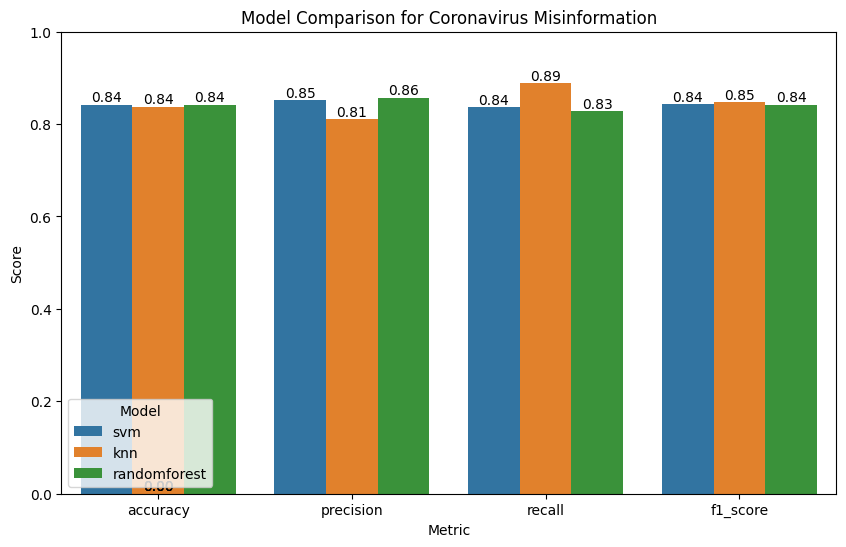

In [ ]:
corona_results_df = pd.DataFrame(corona_validation_results).melt(
    id_vars='model', var_name='metric', value_name='score')
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(data=corona_results_df, x='metric', y='score', hue='model')
plt.title('Model Comparison for Coronavirus Misinformation')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1)

for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'{p.get_height():.2f}',
        ha='center',
        va='bottom'
    )

plt.legend(title='Model', loc='lower left')
plt.savefig(save_model_plot+'Coronavirus/Model_Comparison', format='png')
plt.show()

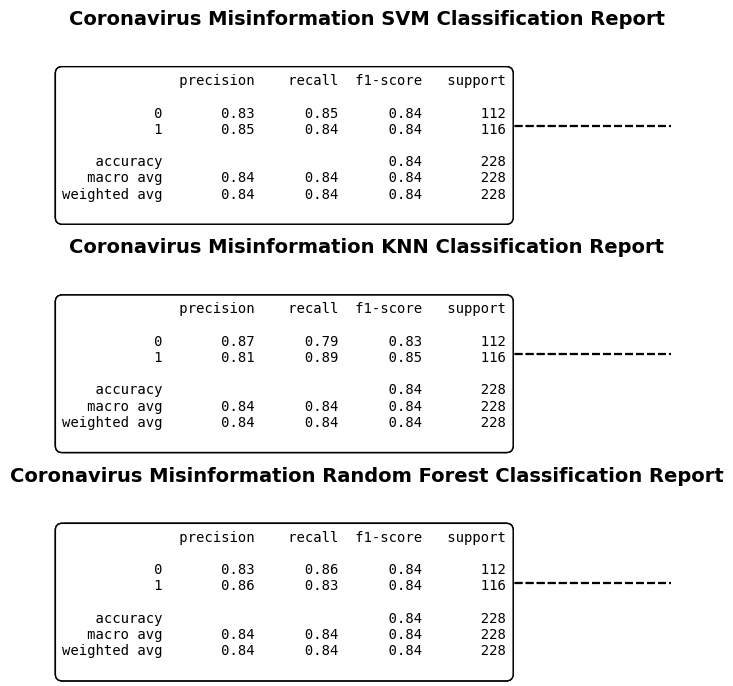

In [ ]:
# Plot Classification Report for Coronavirus Misinformation Models
corona_models = [svm_corona_model, knn_corona_model, corona_randforest_model]
corona_models_preds = [corona_svm_y_pred, corona_knn_y_pred, corona_randomforest_y_pred]
model_names = ['SVM', 'KNN', 'Random Forest']

fig, ax = plt.subplots(3, 1, figsize=(7, 7))

for i, (corona_model_preds, model, model_name) in enumerate(zip(corona_models_preds, corona_models, model_names)):
  for i, (corona_model_preds, model_name) in enumerate(zip(corona_models_preds, model_names)):
    # Generate the classification report
    corona_classification_report = classification_report(corona_val_augmented_labels, corona_model_preds)
    # Add the classification report text to the plot
    ax[i].text(0.0, 1.0, corona_classification_report, fontsize=10, va='top', ha='left', family='monospace', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    # Set the title for each subplot
    ax[i].set_title(f'Coronavirus Misinformation {model_name} Classification Report', fontsize=14, fontweight='bold')
    # Add a line to divide sections
    ax[i].plot([0, 1], [0.97, 0.97], color='black', linewidth=1.5, linestyle='--')  # Add a dashed line at the top
    # Hide the axes
    ax[i].axis('off')
  plt.tight_layout()

  #Save the figure as an image file
  plt.savefig(save_model_plot+'/Coronavirus/SVM&Knn&Randforest_Classification_report.png', bbox_inches='tight')

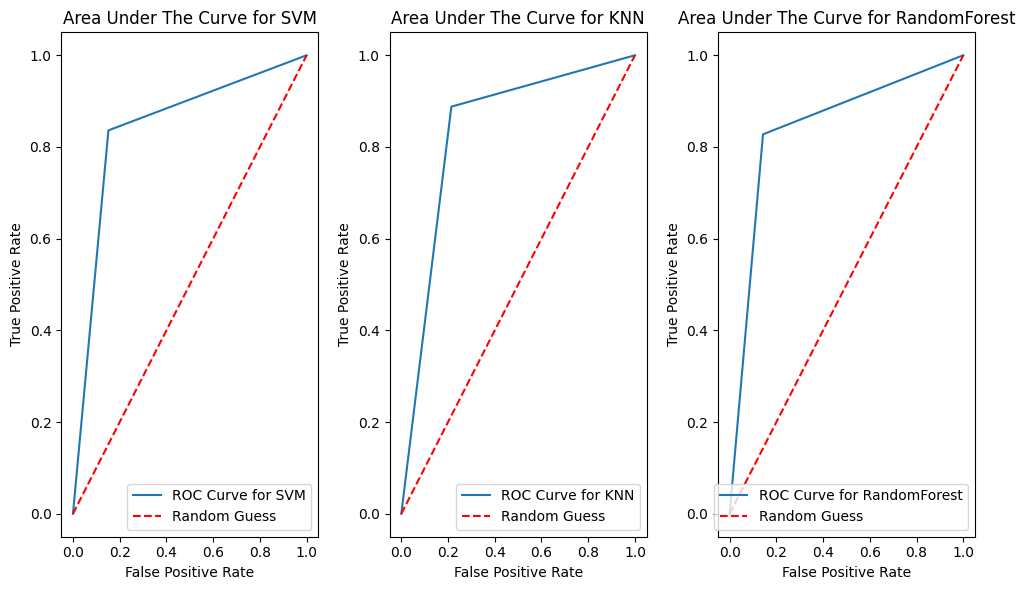

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

fpr, tpr, threshold = roc_curve(corona_val_augmented_labels, np.squeeze(corona_svm_y_pred))
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, label=f'ROC Curve for SVM')
ax[0].plot([0, 1], [0, 1], 'r--', label='Random Guess')
ax[0].set_title(f'Area Under The Curve for SVM')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()

fpr, tpr, threshold = roc_curve(corona_val_augmented_labels, np.squeeze(corona_knn_y_pred))
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, label=f'ROC Curve for KNN')
ax[1].plot([0, 1], [0, 1], 'r--', label='Random Guess')
ax[1].set_title(f'Area Under The Curve for KNN')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()

fpr, tpr, threshold = roc_curve(corona_val_augmented_labels, np.squeeze(corona_randomforest_y_pred))
roc_auc = auc(fpr, tpr)
ax[2].plot(fpr, tpr, label=f'ROC Curve for RandomForest')
ax[2].plot([0, 1], [0, 1], 'r--', label='Random Guess')
ax[2].set_title(f'Area Under The Curve for RandomForest')
ax[2].set_xlabel('False Positive Rate')
ax[2].set_ylabel('True Positive Rate')
ax[2].legend(loc='lower right')

plt.tight_layout()
plt.savefig(save_model_plot+'/Coronavirus/SVMROCAUCCurve.png', format='png')
plt.show()

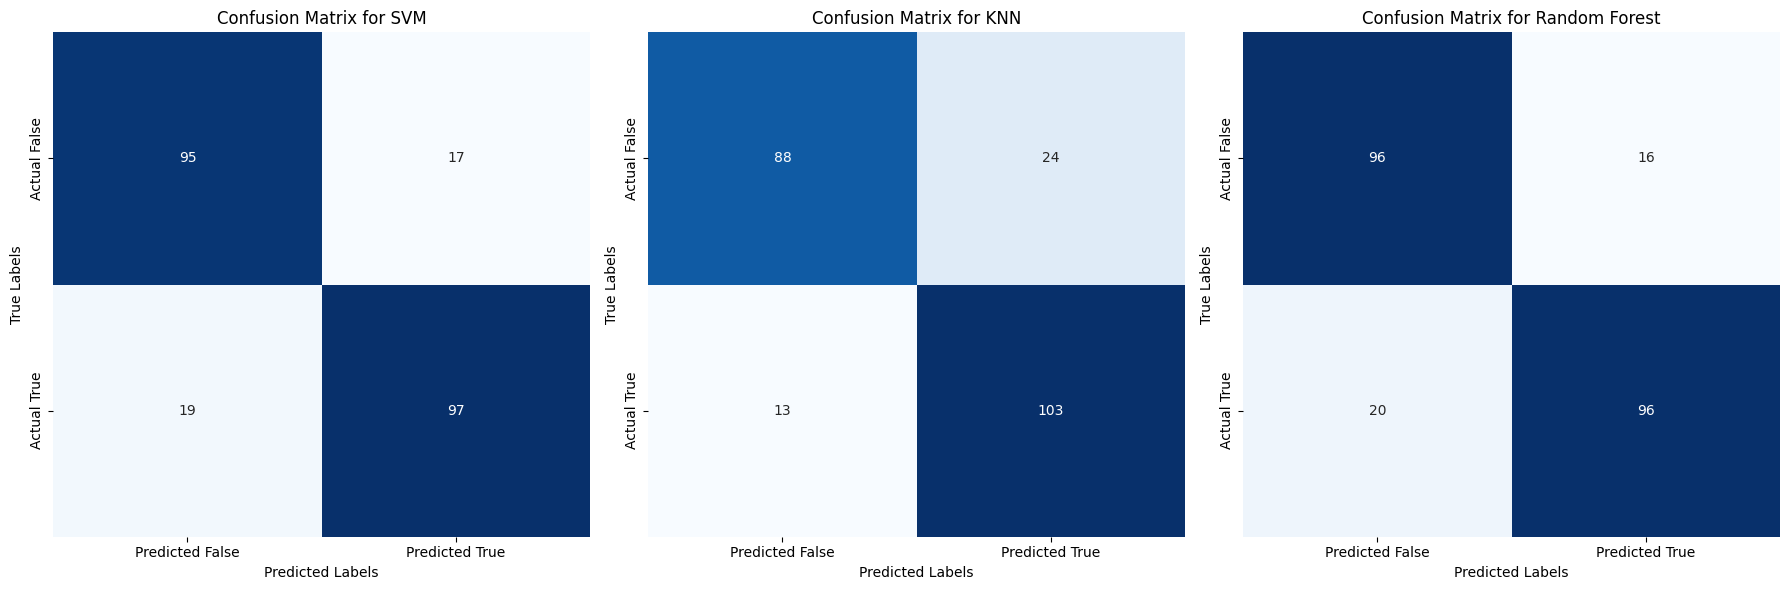

In [ ]:
plot_multiple_confusion_matrices(corona_models_dict, corona_val_augmented_labels, corona_val_augmented_sentences, save_path=save_model_plot+'/Coronavirus/confusionmatrices.png')

#### Maternity Model Comparison

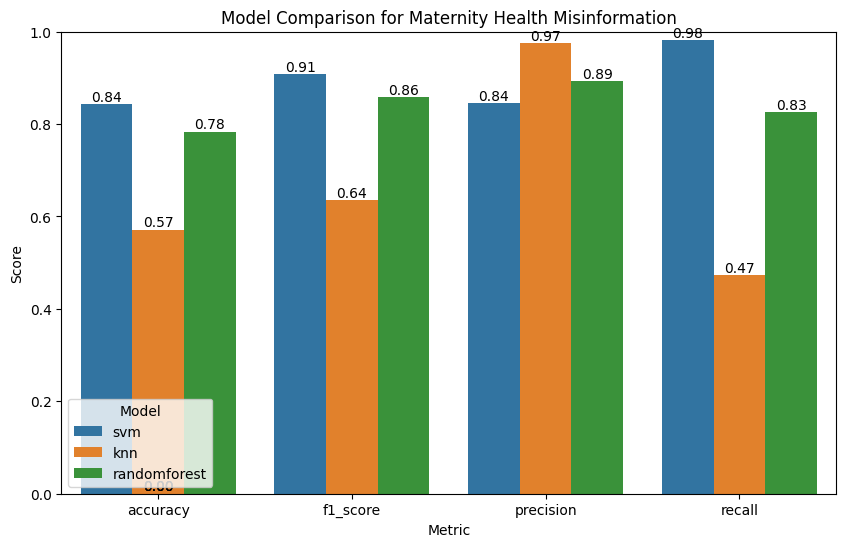

In [ ]:
# Plot Model Metrics
maternity_validation_results = [{'model': result['Validation_Results']['model'],
                       'accuracy': result['Validation_Results']['accuracy'],
                       'f1_score': result['Validation_Results']['f1_score'],
                       'precision': result['Validation_Results']['precision'],
                       'recall': result['Validation_Results']['recall']}
                      for result in maternity_model_results]

# Plot Model Metrics
maternity_results_df = pd.DataFrame(maternity_validation_results).melt(
    id_vars='model', var_name='metric', value_name='score')
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(data=maternity_results_df, x='metric', y='score', hue='model')
plt.title('Model Comparison for Maternity Health Misinformation')

for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'{p.get_height():.2f}',
        ha='center',
        va='bottom'
    )

plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1)
plt.legend(title='Model', loc='lower left')
plt.savefig(save_model_plot+'Maternity_Health/Model_Comparison', format='png')
plt.show()

In [ ]:
with open(save_model_dir + 'Maternity_Models/svm', 'rb') as f:
  svm_maternity_model = pickle.load(f)

maternity_svm_y_pred = svm_maternity_model.predict(maternity_val_augmented_sentences)

with open(save_model_dir + 'Maternity_Models/knn', 'rb') as f:
  knn_maternityy_model = pickle.load(f)

maternity_knn_y_pred = knn_maternityy_model.predict(maternity_val_augmented_sentences)

with open(save_model_dir + 'Maternity_Models/randomforest', 'rb')as f:
  maternity_randomforest_model = pickle.load(f)

maternity_randforest_y_pred = maternity_randomforest_model.predict(maternity_val_augmented_sentences)

maternity_models_dict = {
    'SVM': svm_maternity_model,
    'KNN': knn_maternityy_model,
    'RandomForest': maternity_randomforest_model
}

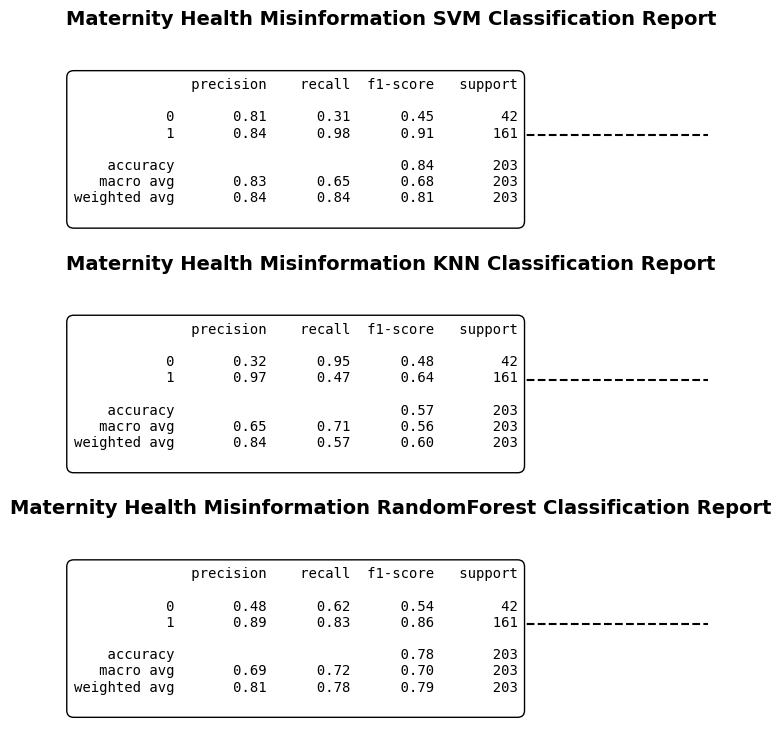

In [ ]:
# Plot Classification Report for Coronavirus Misinformation Models
maternity_models = [svm_maternity_model, knn_maternityy_model, maternity_randomforest_model]
maternity_models_preds = [maternity_svm_y_pred, maternity_knn_y_pred, maternity_randforest_y_pred]
model_names = ['SVM', 'KNN', 'RandomForest']

fig, ax = plt.subplots(3, 1, figsize=(9, 9))

for i, (model_preds, model, model_name) in enumerate(zip(maternity_models_preds, maternity_models, model_names)):
  maternity_classification_report = classification_report(maternity_val_augmented_labels, model_preds)
  ax[i].text(0.0, 1.0, maternity_classification_report, fontsize=10, va='top', ha='left', family='monospace', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
  # Set the title for each subplot
  ax[i].set_title(f'Maternity Health Misinformation {model_name} Classification Report', fontsize=14, fontweight='bold')
  # Add a line to divide sections
  ax[i].plot([0, 1], [0.97, 0.97], color='black', linewidth=1.5, linestyle='--')  # Add a dashed line at the top
  # Hide the axes
  ax[i].axis('off')

  #Save the figure as an image file
  plt.savefig(save_model_plot+'/Maternity_Health/SVM&Knn_Classification_report.png', bbox_inches='tight')

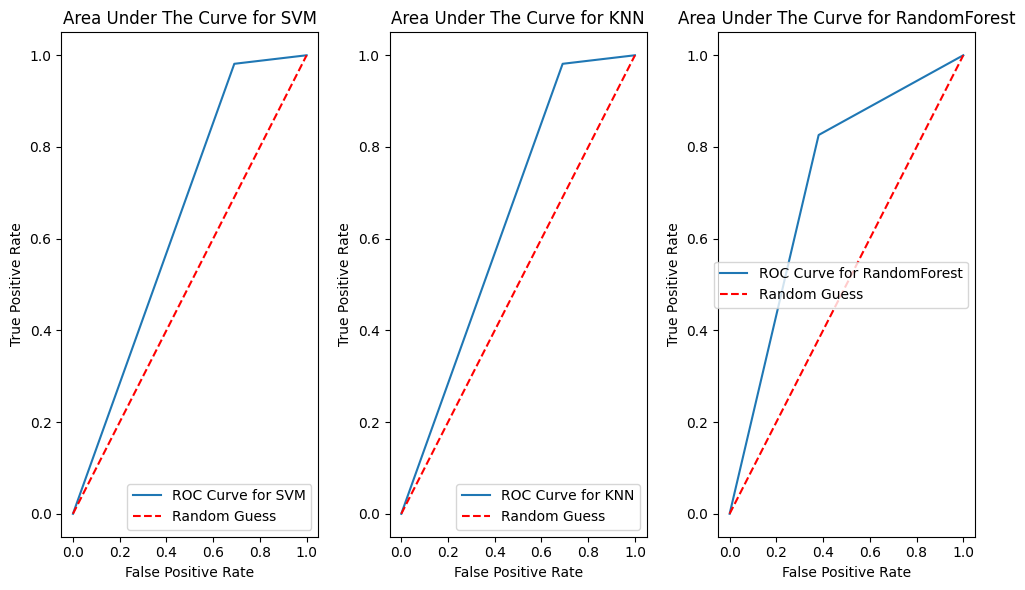

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

fpr, tpr, threshold = roc_curve(maternity_val_augmented_labels, np.squeeze(maternity_svm_y_pred))
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, label=f'ROC Curve for SVM')
ax[0].plot([0, 1], [0, 1], 'r--', label='Random Guess')
ax[0].set_title(f'Area Under The Curve for SVM')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()

fpr, tpr, threshold = roc_curve(maternity_val_augmented_labels, np.squeeze(maternity_svm_y_pred))
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, label=f'ROC Curve for KNN')
ax[1].plot([0, 1], [0, 1], 'r--', label='Random Guess')
ax[1].set_title(f'Area Under The Curve for KNN')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()

fpr, tpr, threshold = roc_curve(maternity_val_augmented_labels, np.squeeze(maternity_randforest_y_pred))
roc_auc = auc(fpr, tpr)
ax[2].plot(fpr, tpr, label=f'ROC Curve for RandomForest')
ax[2].plot([0, 1], [0, 1], 'r--', label='Random Guess')
ax[2].set_title(f'Area Under The Curve for RandomForest')
ax[2].set_xlabel('False Positive Rate')
ax[2].set_ylabel('True Positive Rate')
ax[2].legend()

plt.tight_layout()
plt.savefig(save_model_plot+'/Maternity_Health/SVMROCAUCCurve.png', format='png')
plt.show()

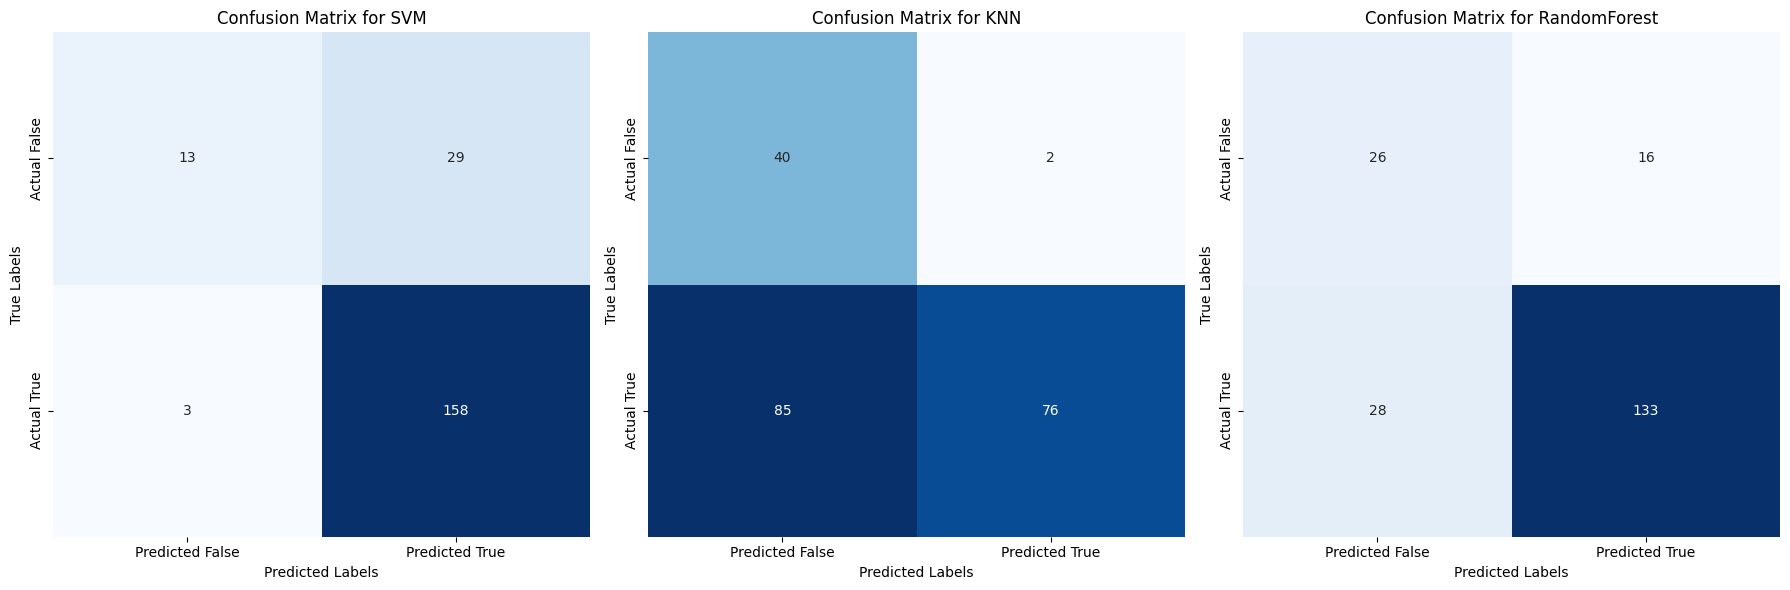

In [ ]:
plot_multiple_confusion_matrices(maternity_models_dict, maternity_val_augmented_labels, maternity_val_augmented_sentences, save_path=save_model_plot+'/Maternity_Health/confusionmatrices.png')

#### LassaFever Model Comparison

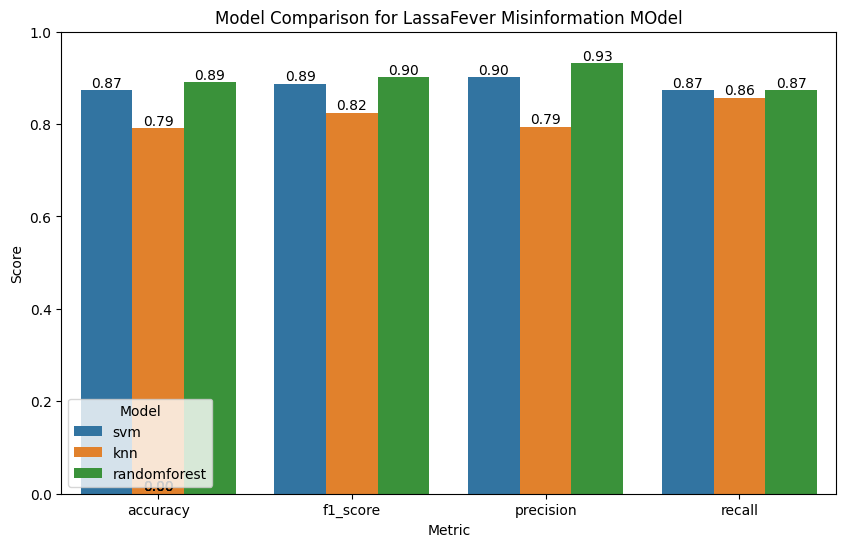

In [ ]:
# Plot Model Metrics
lassa_validation_results = [{'model': result['Validation_Results']['model'],
                       'accuracy': result['Validation_Results']['accuracy'],
                       'f1_score': result['Validation_Results']['f1_score'],
                       'precision': result['Validation_Results']['precision'],
                       'recall': result['Validation_Results']['recall']}
                      for result in lassafever_model_results]

# Plot Model Metrics
lassafever_results_df = pd.DataFrame(lassa_validation_results).melt(
    id_vars='model', var_name='metric', value_name='score')
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(data=lassafever_results_df, x='metric', y='score', hue='model')
plt.title('Model Comparison for LassaFever Misinformation MOdel')

for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'{p.get_height():.2f}',
        ha='center',
        va='bottom'
    )

plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1)
plt.legend(title='Model', loc='lower left')
plt.savefig(save_model_plot+'Lassafever/Model_Comparison', format='png')
plt.show()

In [ ]:
with open(save_model_dir + 'Lassafever_Models/svm', 'rb') as f:
  svm_lassa_model = pickle.load(f)

lassa_svm_y_pred = svm_lassa_model.predict(lassa_val_sentences)

with open(save_model_dir + 'Lassafever_Models/knn', 'rb') as f:
  knn_lassa_model = pickle.load(f)

lassa_knn_y_pred = knn_lassa_model.predict(lassa_val_sentences)

with open(save_model_dir + 'Lassafever_Models/randomforest', 'rb') as f:
  randomforest_lassa_model = pickle.load(f)

randomforest_lassa_y_pred = randomforest_lassa_model.predict(lassa_val_sentences)

lassa_model_dict = {
    'SVM': svm_lassa_model,
    'KNN': knn_lassa_model,
    'RandomForest': randomforest_lassa_model
}

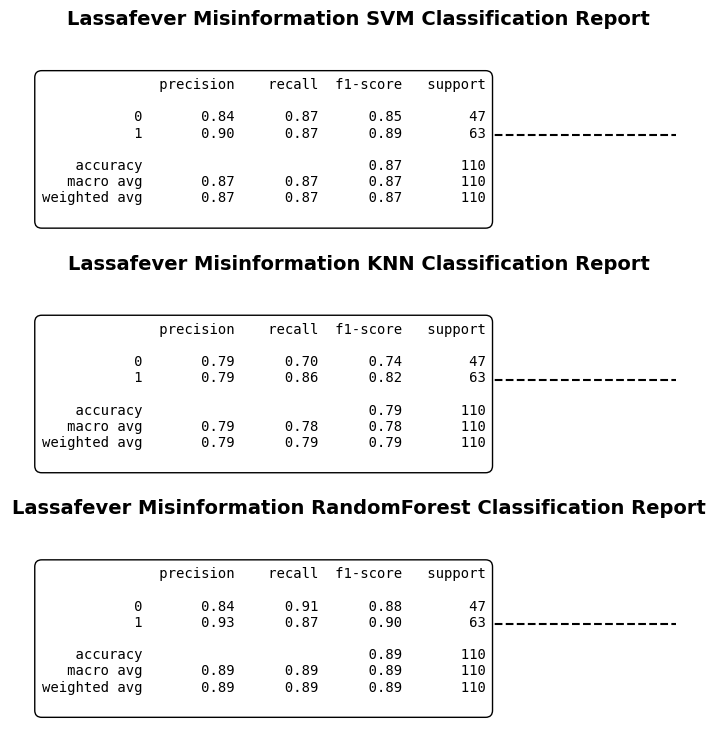

In [ ]:
# Plot Classification Report for Coronavirus Misinformation Models
lassafever_models = [svm_lassa_model, knn_lassa_model, randomforest_lassa_model]
lassafever_models_preds = [lassa_svm_y_pred, lassa_knn_y_pred, randomforest_lassa_y_pred]
model_names = ['SVM', 'KNN', 'RandomForest']

fig, ax = plt.subplots(3, 1, figsize=(9, 9))

for i, (model_preds, model, model_name) in enumerate(zip(lassafever_models_preds, lassafever_models, model_names)):
  lassafever_classification_report = classification_report(lassa_val_labels, model_preds)

  ax[i].text(0.0, 1.0, lassafever_classification_report, fontsize=10, va='top', ha='left', family='monospace', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
  # Set the title for each subplot
  ax[i].set_title(f'Lassafever Misinformation {model_name} Classification Report', fontsize=14, fontweight='bold')
  # Add a line to divide sections
  ax[i].plot([0, 1], [0.97, 0.97], color='black', linewidth=1.5, linestyle='--')  # Add a dashed line at the top
  # Hide the axes
  ax[i].axis('off')

  #Save the figure as an image file
  plt.savefig(save_model_plot+'/Lassafever/SVM&Knn_Classification_report.png', bbox_inches='tight')

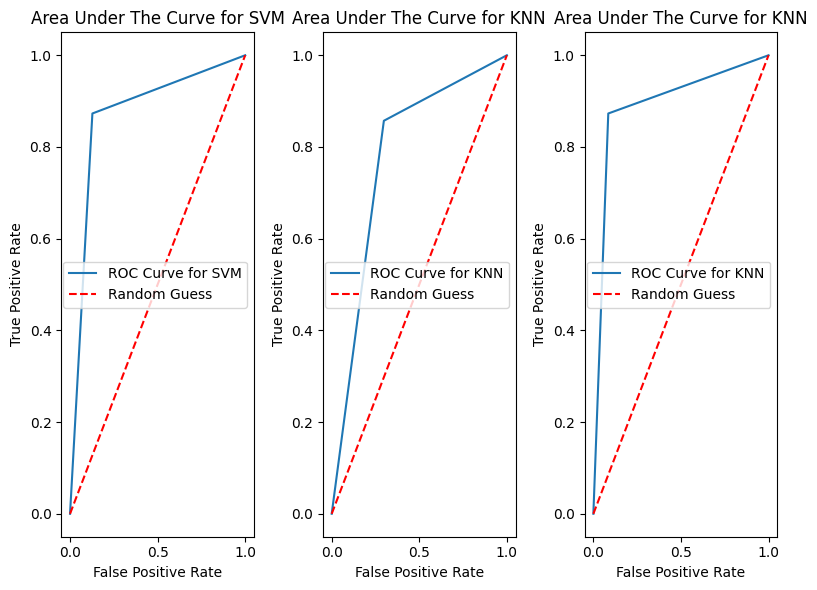

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 6))

fpr, tpr, threshold = roc_curve(lassa_val_labels, np.squeeze(lassa_svm_y_pred))
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, label=f'ROC Curve for SVM')
ax[0].plot([0, 1], [0, 1], 'r--', label='Random Guess')
ax[0].set_title(f'Area Under The Curve for SVM')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()

fpr, tpr, threshold = roc_curve(lassa_val_labels, np.squeeze(lassa_knn_y_pred))
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, label=f'ROC Curve for KNN')
ax[1].plot([0, 1], [0, 1], 'r--', label='Random Guess')
ax[1].set_title(f'Area Under The Curve for KNN')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()

fpr, tpr, threshold = roc_curve(lassa_val_labels, np.squeeze(randomforest_lassa_y_pred))
roc_auc = auc(fpr, tpr)
ax[2].plot(fpr, tpr, label=f'ROC Curve for KNN')
ax[2].plot([0, 1], [0, 1], 'r--', label='Random Guess')
ax[2].set_title(f'Area Under The Curve for KNN')
ax[2].set_xlabel('False Positive Rate')
ax[2].set_ylabel('True Positive Rate')
ax[2].legend()

plt.tight_layout()
plt.savefig(save_model_plot+'/Lassafever/SVMROCAUCCurve.png', format='png')
plt.show()

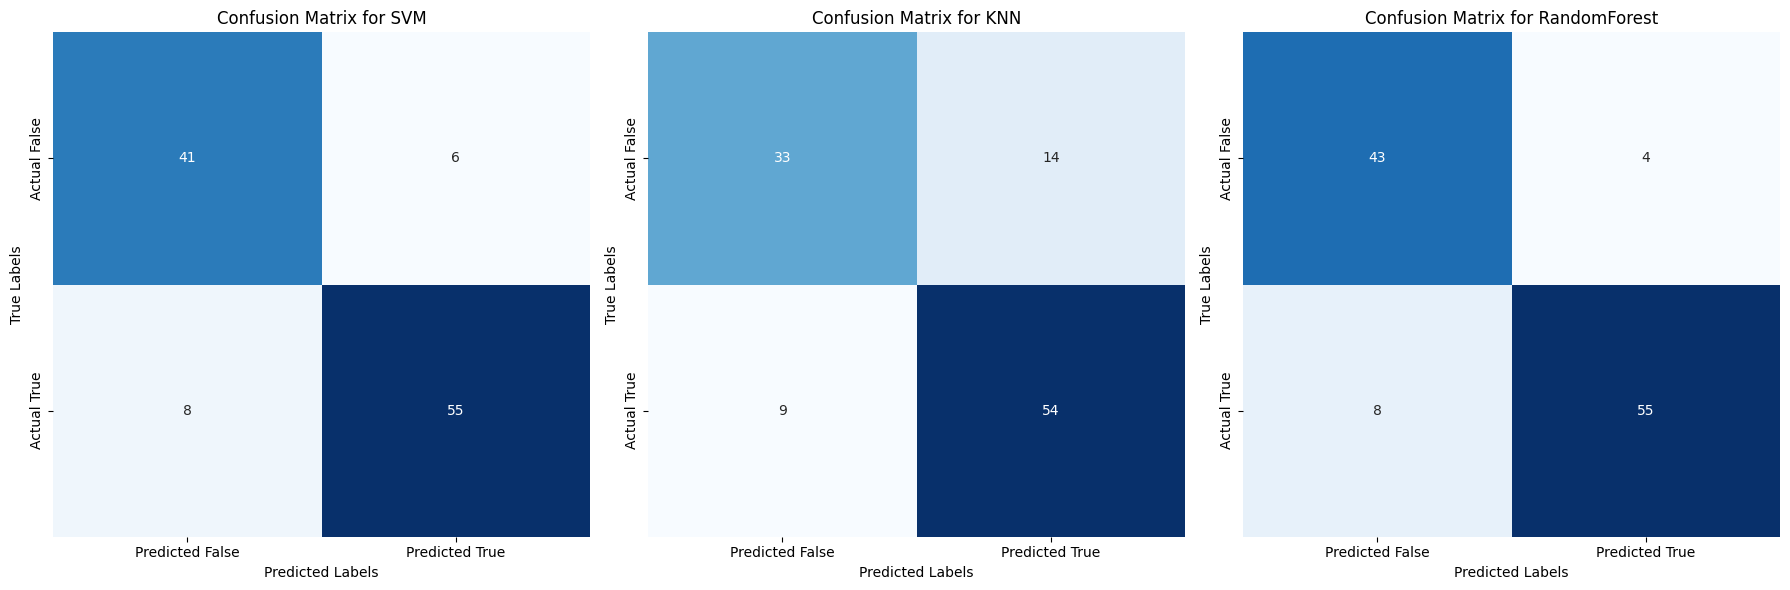

In [ ]:
plot_multiple_confusion_matrices(lassa_model_dict, lassa_val_labels, lassa_val_sentences, save_path=save_model_plot+'/Lassafever/confusionmatrices.png')

#### *From above, it's obvious that the SVM model, performed bettter, for the three dataset*

## Predicting on the Best Performing Model using Custom Text

In [ ]:
class Classify_Health_Info:
  def __init__(self, model_name, text=None):
    self.model_name = model_name
    self.text = text

  def load_model(self):
    '''
    Function to load model, given the name of the model, and
    return the model

    args:
    name: name of model could be 'Corona_Model', 'Lassafever_Model' or 'Maternity_Health_Model'

    returns: Loaded model in pkl format
    '''
    if self.model_name == 'Corona_Model':
      with open(save_model_dir + 'Coronavirus_Models/svm', 'rb') as f:
        svm_corona_model = pickle.load(f)
      return svm_corona_model

    elif self.model_name == 'Lassafever_Model':
      with open(save_model_dir + 'Lassafever_Models/svm', 'rb') as f:
        svm_lassa_model = pickle.load(f)
      return svm_lassa_model

    elif self.model_name == 'Maternity_Health_Model':
      with open(save_model_dir + 'Maternity_Models/svm', 'rb') as f:
        svm_materniy_model = pickle.load(f)
      return svm_materniy_model
    else:
      print('Unknown Model Name Parameter, Model name could either be Corona_Model, Lassafever_Model or Maternity_Health_Model')

  def predict(self):
    model = self.load_model()

    pred_class_list = [False, True]
    preds = model.predict([self.text])
    pred_class = pred_class_list[np.squeeze(preds)]

    return pred_class

In [ ]:
Classify_Health_Info('Maternity_Health_Model', 'pregnant are going through a lot').predict()

True

## Test Model on User Interface

In [3]:
!pip install streamlit
!pip install py-localtunnel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [4]:
# Generate tunnel password
!wget -q -O - ipv4.icanhazip.com

34.16.173.34


In [ ]:
!streamlit run health_misinformation_detection_UI.py & npx localtunnel --port 8501